02 – Time Index Audit, Resampling, Early EDA, Data Quality

This notebook:

Loads scada_wide.parquet + signal_catalog.parquet

Wide→Long normalization

Time index audit (duplicates/gaps/median dt)

Resample to standard timebase (e.g., 5min)

Early EDA (missingness, distributions, sanity plots)

DQ scoring + monitoring confidence

Writes Parquet:

outputs/stages/scada_long.parquet

outputs/stages/scada_rs.parquet

outputs/stages/time_audit.parquet

outputs/stages/dq_report.parquet

In [38]:
import importlib
from pathlib import Path

import pandas as pd

import pv_fleet_health.scada_reshape as scada_reshape

importlib.reload(scada_reshape)
from pv_fleet_health.config import load_config_yaml
from pv_fleet_health.io import save_parquet
from pv_fleet_health.paths import Paths
from pv_fleet_health.plots import plot_missingness_bars
from pv_fleet_health.scada_reshape import wide_to_long
from pv_fleet_health.timebase import compute_time_index_audit, resample_signals

ROOT = Path("..").resolve()
paths = Paths(ROOT)
paths.ensure()
cfg = load_config_yaml(str(ROOT / "config.yaml"))

In [32]:
scada_wide = pd.read_parquet(paths.stage_dir / "scada_wide.parquet")
signal_catalog = pd.read_parquet(paths.stage_dir / "signal_catalog.parquet")

print("Loaded scada_wide:", scada_wide.shape)
print("Loaded signal_catalog:", signal_catalog.shape)

# Optional: debug mode
if cfg.selected_plant is not None:
    keep_cols = [cfg.timestamp_col] + signal_catalog["raw_column_name"].tolist()
    scada_wide = scada_wide[keep_cols].copy()
    print("Filtered debug plant columns:", scada_wide.shape)

Loaded scada_wide: (2400, 244)
Loaded signal_catalog: (243, 12)


In [33]:
scada_long = wide_to_long(scada_wide, signal_catalog, cfg.timestamp_col)
print("scada_long:", scada_long.shape)
print(scada_long[["ts", "plant_name", "component_type", "canonical_signal", "value"]].head(5))

save_parquet(scada_long, str(paths.stage_dir / "scada_long.parquet"))

scada_long: (583200, 11)
                         ts                      plant_name component_type  \
0 2025-12-01 00:15:00+02:00  Solar Concept 3721 KWp Lexaina          array   
1 2025-12-01 00:30:00+02:00  Solar Concept 3721 KWp Lexaina          array   
2 2025-12-01 00:45:00+02:00  Solar Concept 3721 KWp Lexaina          array   
3 2025-12-01 01:00:00+02:00  Solar Concept 3721 KWp Lexaina          array   
4 2025-12-01 01:15:00+02:00  Solar Concept 3721 KWp Lexaina          array   

        canonical_signal     value  
0  ac_frequency_error_hz -1.890000  
1  ac_frequency_error_hz -0.643333  
2  ac_frequency_error_hz -1.434444  
3  ac_frequency_error_hz  0.094444  
4  ac_frequency_error_hz -2.107778  


In [34]:
time_audit = compute_time_index_audit(scada_long)
print("Time audit rows:", len(time_audit))
display(time_audit.sort_values("dup_frac", ascending=False).head(10))

save_parquet(time_audit, str(paths.stage_dir / "time_audit.parquet"))

Time audit rows: 1


plant_name                    min_ts  \
0  Solar Concept 3721 KWp Lexaina 2025-12-01 00:15:00+02:00   

                     max_ts  dup_frac  median_dt_min       n  
0 2025-12-26 00:00:00+02:00  0.995885           15.0  583200

In [35]:
scada_rs = resample_signals(scada_long, cfg)
print("scada_rs:", scada_rs.shape)
print(scada_rs.head())

save_parquet(scada_rs, str(paths.stage_dir / "scada_rs.parquet"))

scada_rs: (504000, 8)
                         ts  value_rs                      plant_name  \
0 2025-12-01 00:15:00+02:00 -1.890000  Solar Concept 3721 KWp Lexaina   
1 2025-12-01 00:30:00+02:00 -0.643333  Solar Concept 3721 KWp Lexaina   
2 2025-12-01 00:45:00+02:00 -1.434444  Solar Concept 3721 KWp Lexaina   
3 2025-12-01 01:00:00+02:00  0.094444  Solar Concept 3721 KWp Lexaina   
4 2025-12-01 01:15:00+02:00 -2.107778  Solar Concept 3721 KWp Lexaina   

  component_type component_id       canonical_signal unit     signal_type  
0          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
1          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
2          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
3          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
4          array            1  ac_frequency_error_hz   Hz  instant_or_avg  


In [36]:
def filter_scada_rs(scada_rs, plant_name, component_type, component_id, n=5):
    # Ensure the plant exists in the data
    assert plant_name in scada_rs["plant_name"].unique(), "plant_name not found"

    grouped = scada_rs.groupby(["plant_name", "component_type", "component_id"])
    df = grouped.get_group((plant_name, component_type, component_id))

    # Assert uniqueness in the filtered data
    assert df["plant_name"].nunique() == 1, "plant_name is not unique in filtered result"
    if "nameplate_kwp" in df.columns:
        assert df["nameplate_kwp"].nunique() == 1, "nameplate_kwp is not unique in filtered result"
    if "panel_area_m2" in df.columns:
        assert df["panel_area_m2"].nunique() == 1, "panel_area_m2 is not unique in filtered result"

    # Preserve the metadata columns if present
    keep_cols = ["nameplate_kwp", "panel_area_m2"]
    keep_cols = [c for c in keep_cols if c in df.columns]

    print(df.head(n))
    print(df.columns)
    print(df["canonical_signal"].unique())

    return df


df_filtered = filter_scada_rs(
    scada_rs,
    plant_name="Solar Concept 3721 KWp Lexaina",
    component_type="array",
    component_id="1",
)

                         ts  value_rs                      plant_name  \
0 2025-12-01 00:15:00+02:00 -1.890000  Solar Concept 3721 KWp Lexaina   
1 2025-12-01 00:30:00+02:00 -0.643333  Solar Concept 3721 KWp Lexaina   
2 2025-12-01 00:45:00+02:00 -1.434444  Solar Concept 3721 KWp Lexaina   
3 2025-12-01 01:00:00+02:00  0.094444  Solar Concept 3721 KWp Lexaina   
4 2025-12-01 01:15:00+02:00 -2.107778  Solar Concept 3721 KWp Lexaina   

  component_type component_id       canonical_signal unit     signal_type  
0          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
1          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
2          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
3          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
4          array            1  ac_frequency_error_hz   Hz  instant_or_avg  
Index(['ts', 'value_rs', 'plant_name', 'component_type', 'component_id',
       'canonical_signal', 'unit

                           value_rs                      plant_name  \
ts                                                                    
2025-12-01 00:15:00+02:00 -1.890000  Solar Concept 3721 KWp Lexaina   
2025-12-01 00:30:00+02:00 -0.643333  Solar Concept 3721 KWp Lexaina   
2025-12-01 00:45:00+02:00 -1.434444  Solar Concept 3721 KWp Lexaina   
2025-12-01 01:00:00+02:00  0.094444  Solar Concept 3721 KWp Lexaina   
2025-12-01 01:15:00+02:00 -2.107778  Solar Concept 3721 KWp Lexaina   

                          component_type component_id       canonical_signal  \
ts                                                                             
2025-12-01 00:15:00+02:00          array            1  ac_frequency_error_hz   
2025-12-01 00:30:00+02:00          array            1  ac_frequency_error_hz   
2025-12-01 00:45:00+02:00          array            1  ac_frequency_error_hz   
2025-12-01 01:00:00+02:00          array            1  ac_frequency_error_hz   
2025-12-01 01:15:00+02

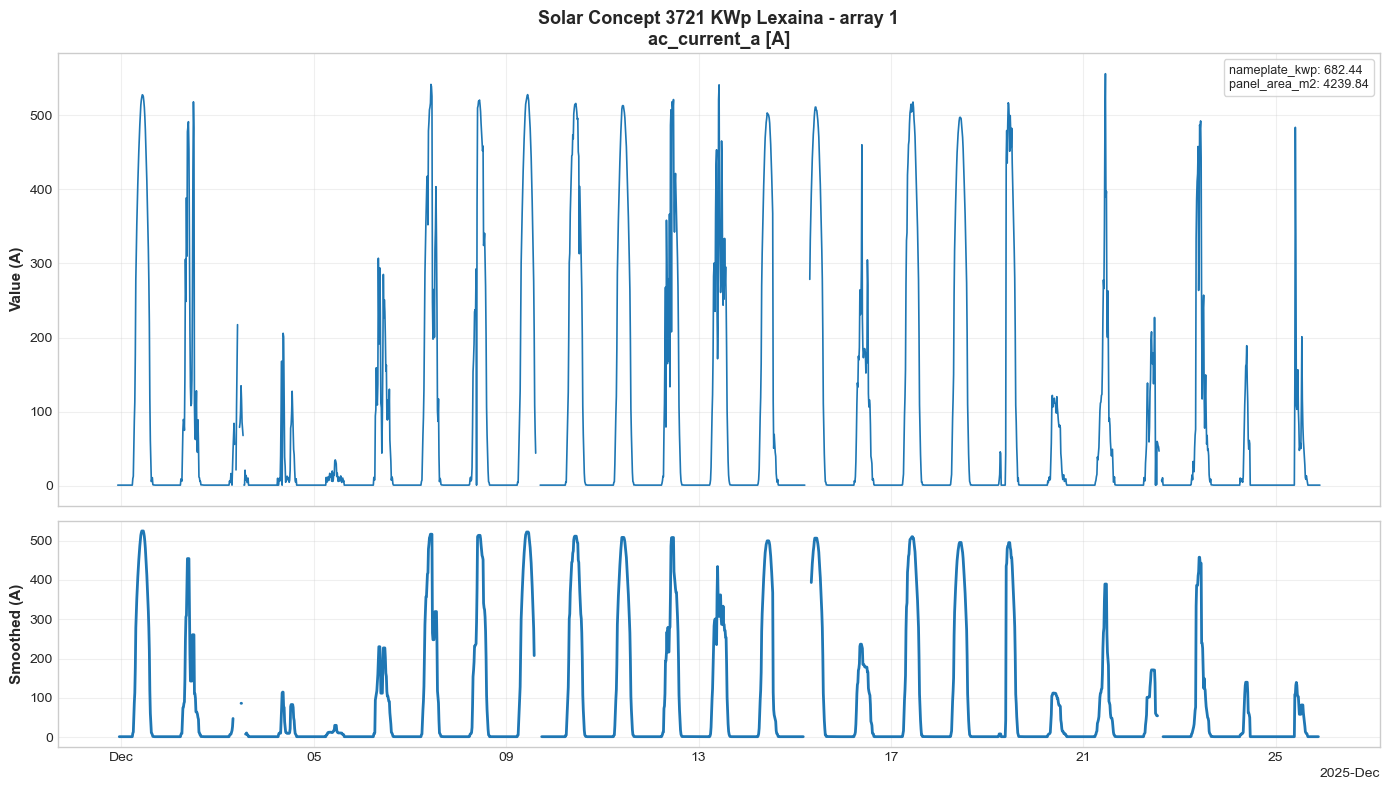

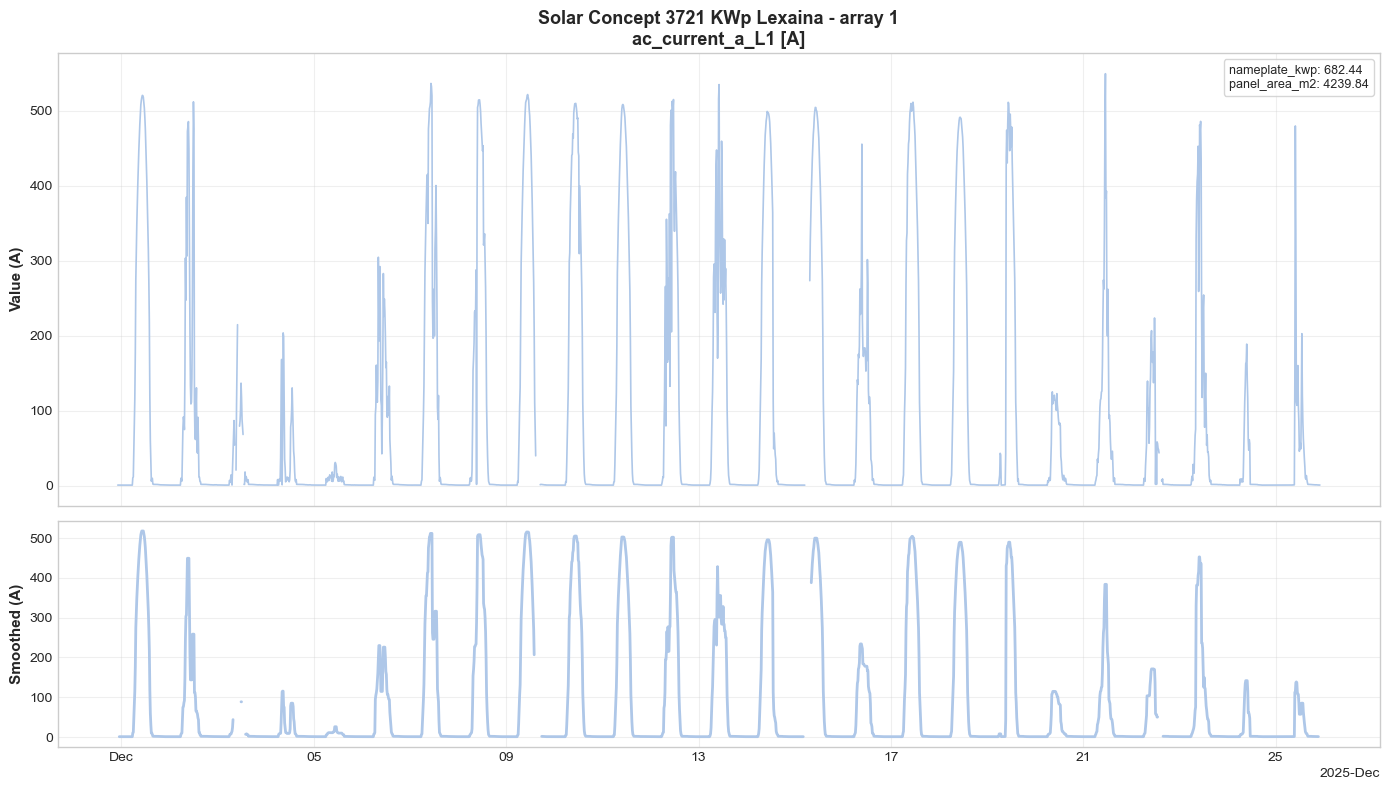

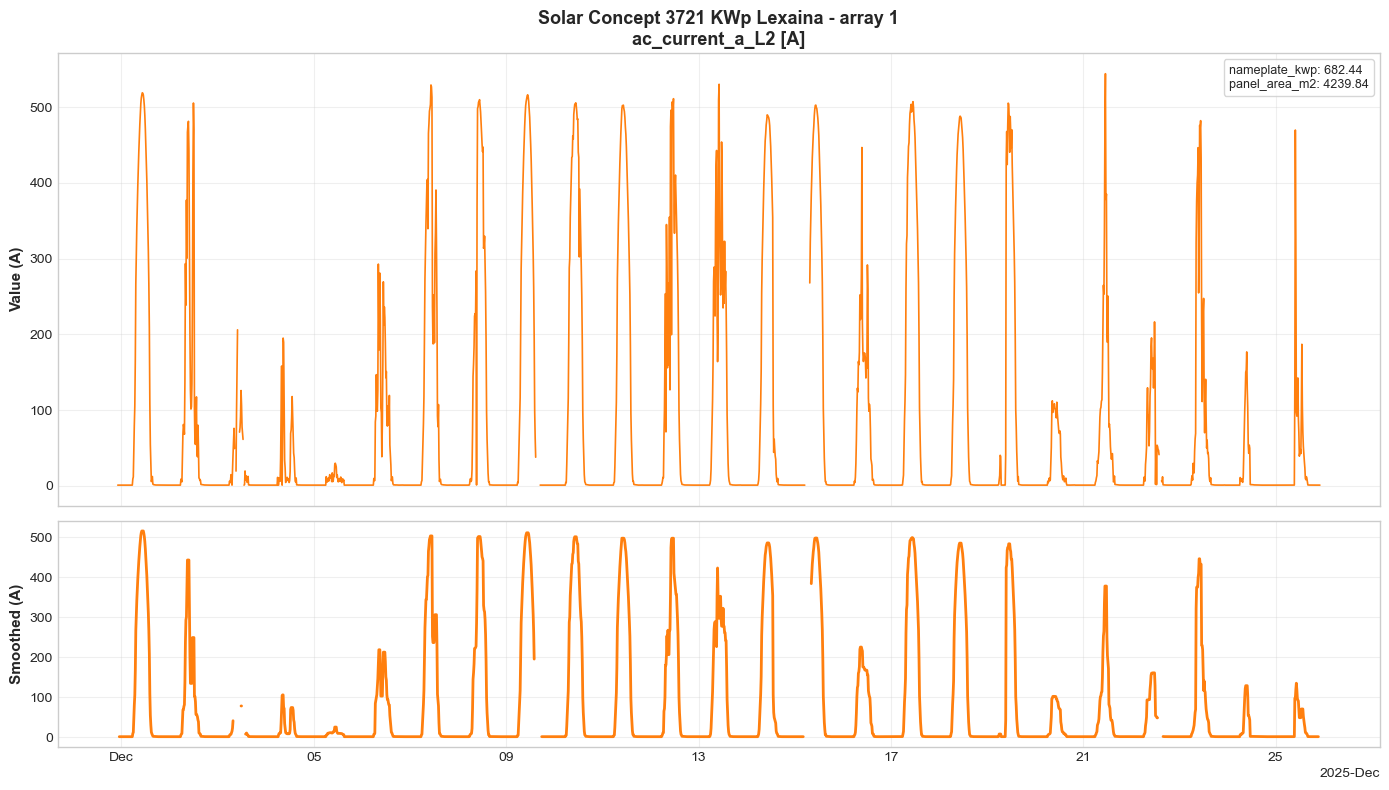

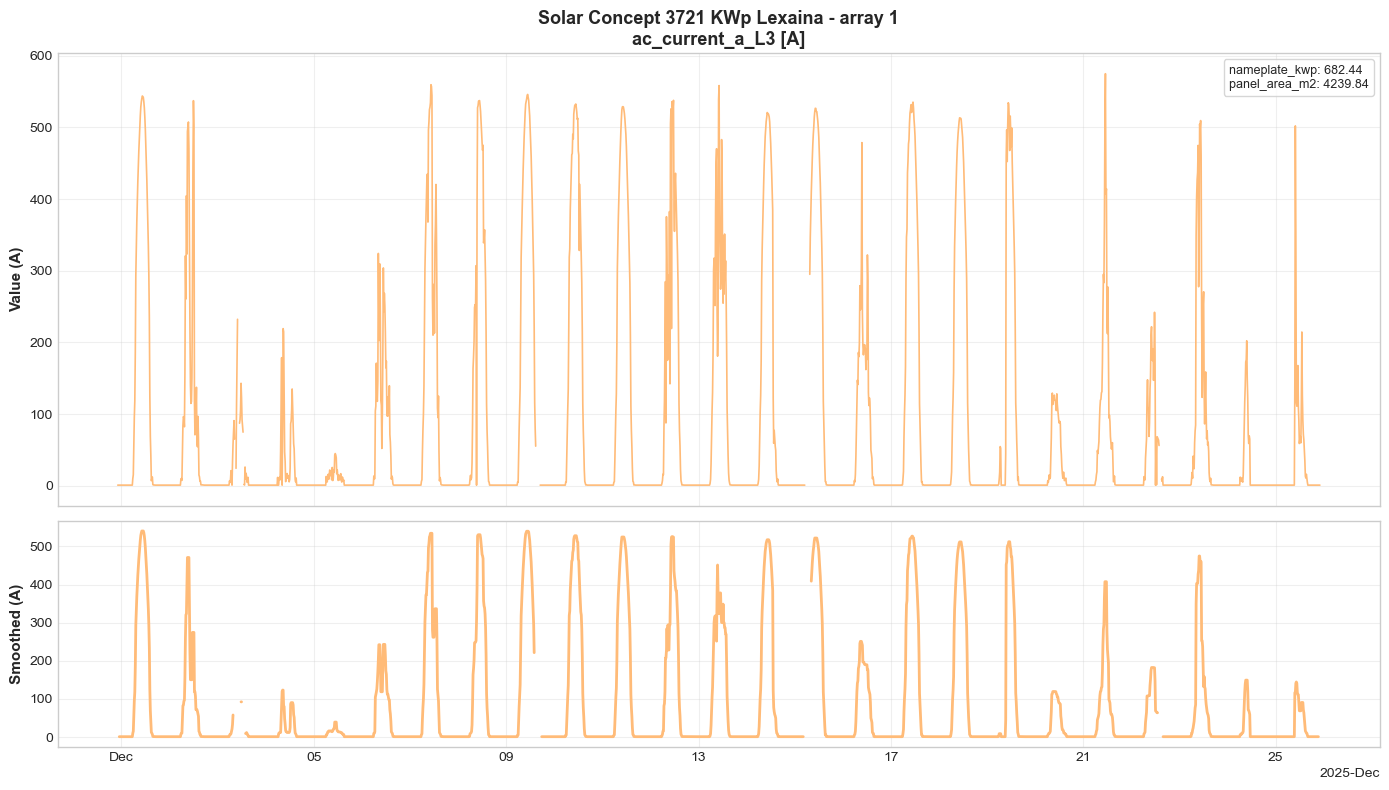

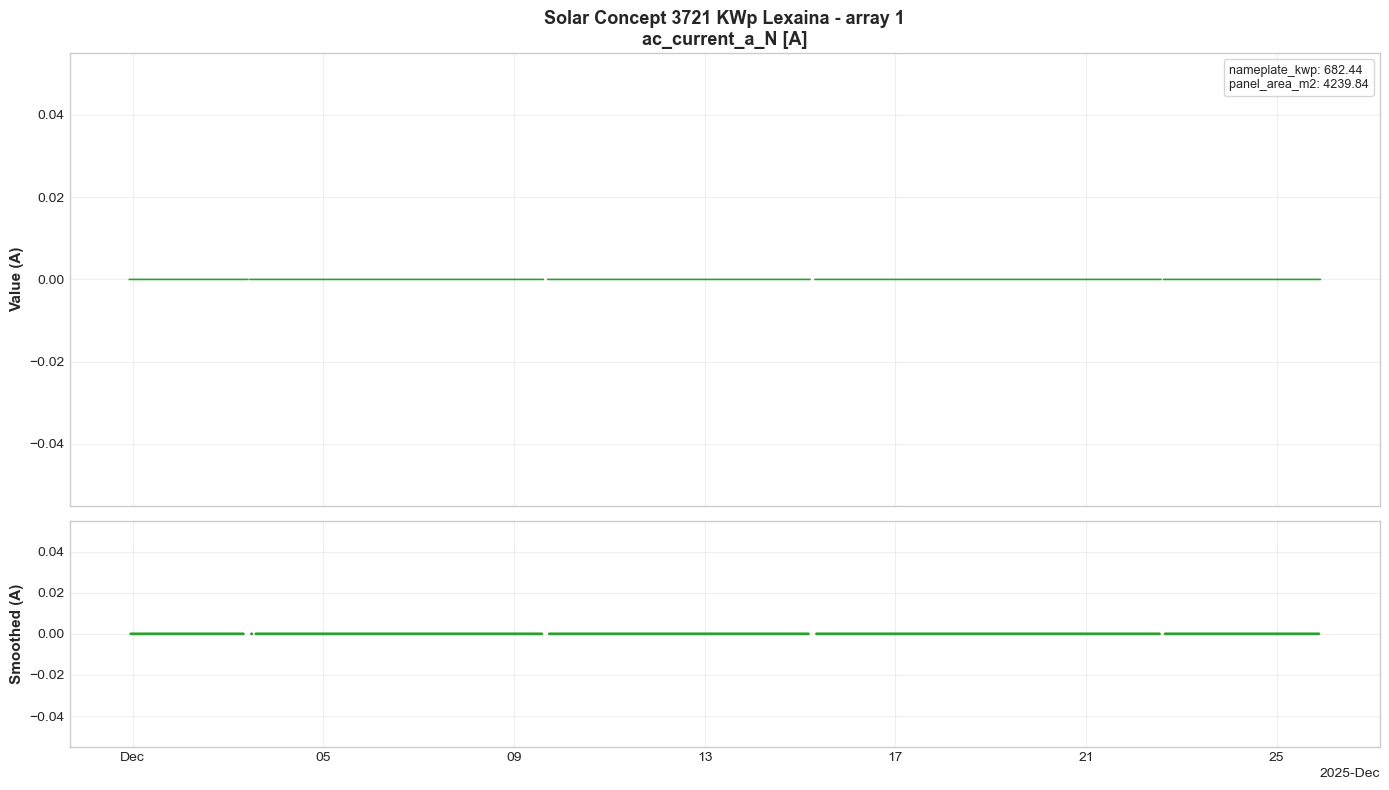

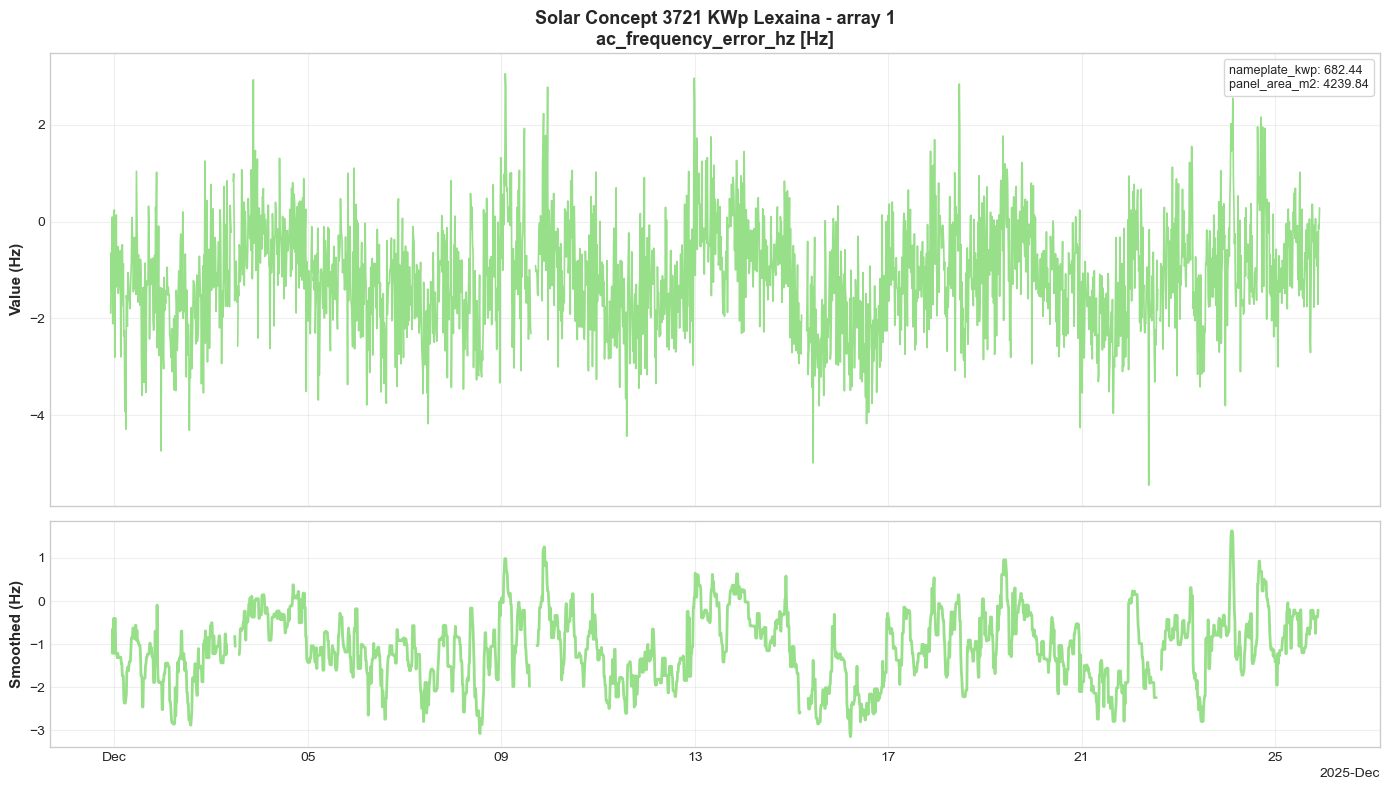

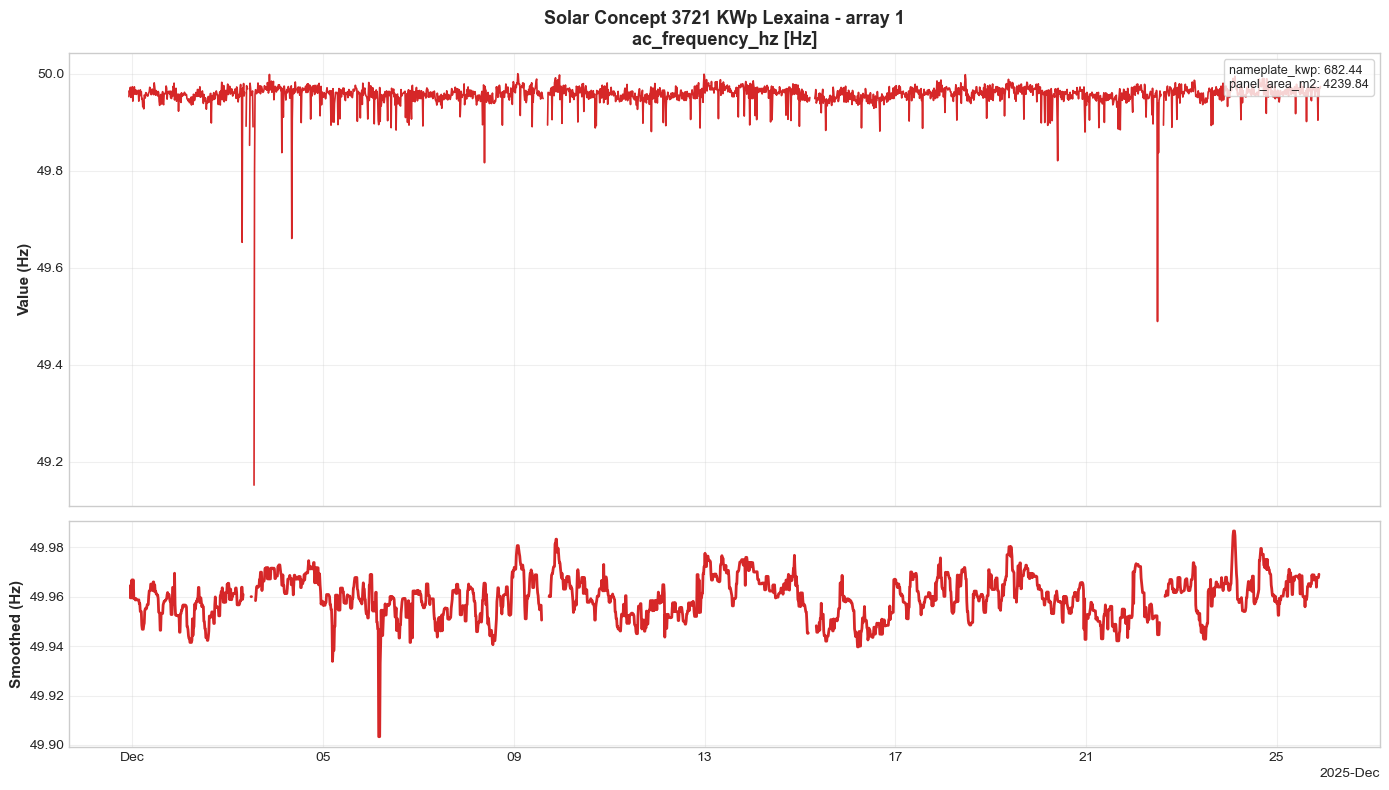

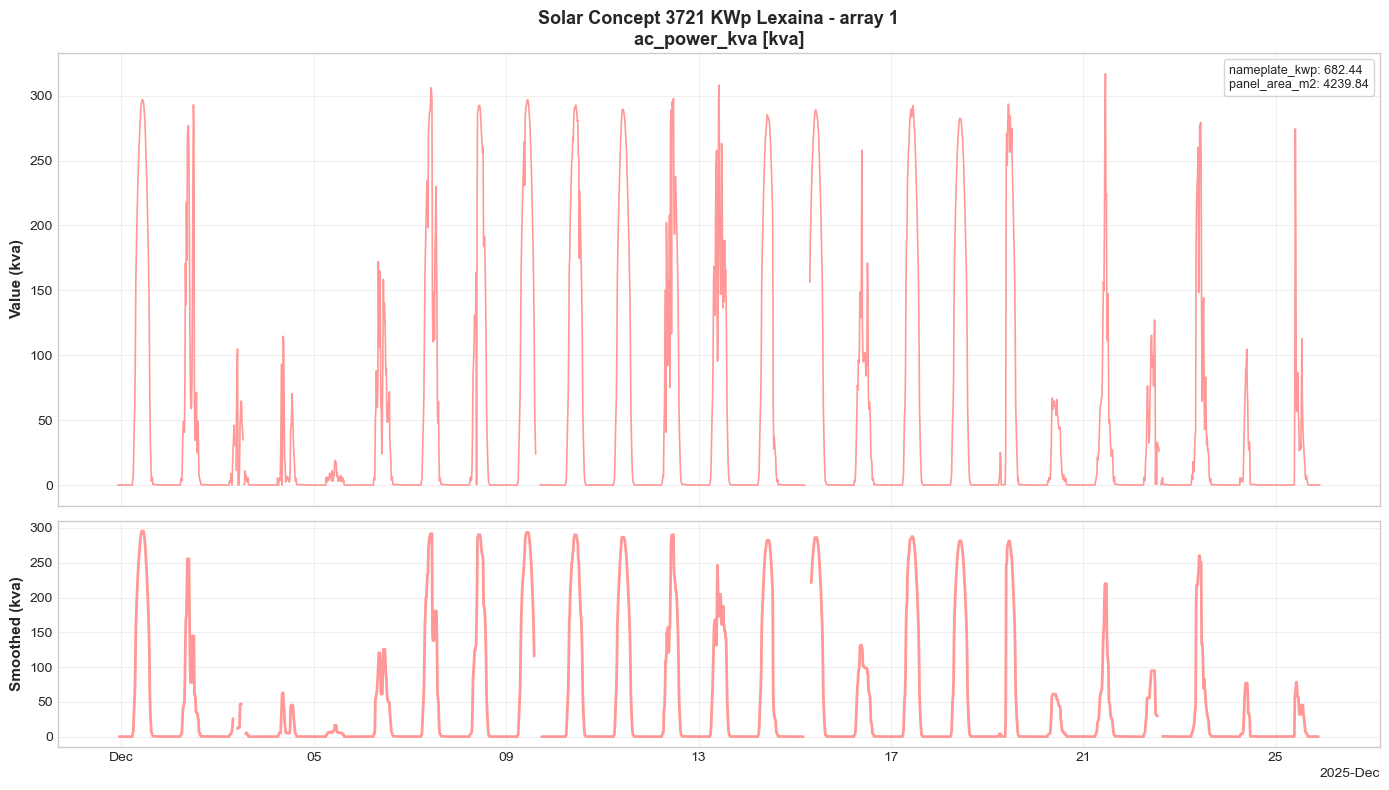

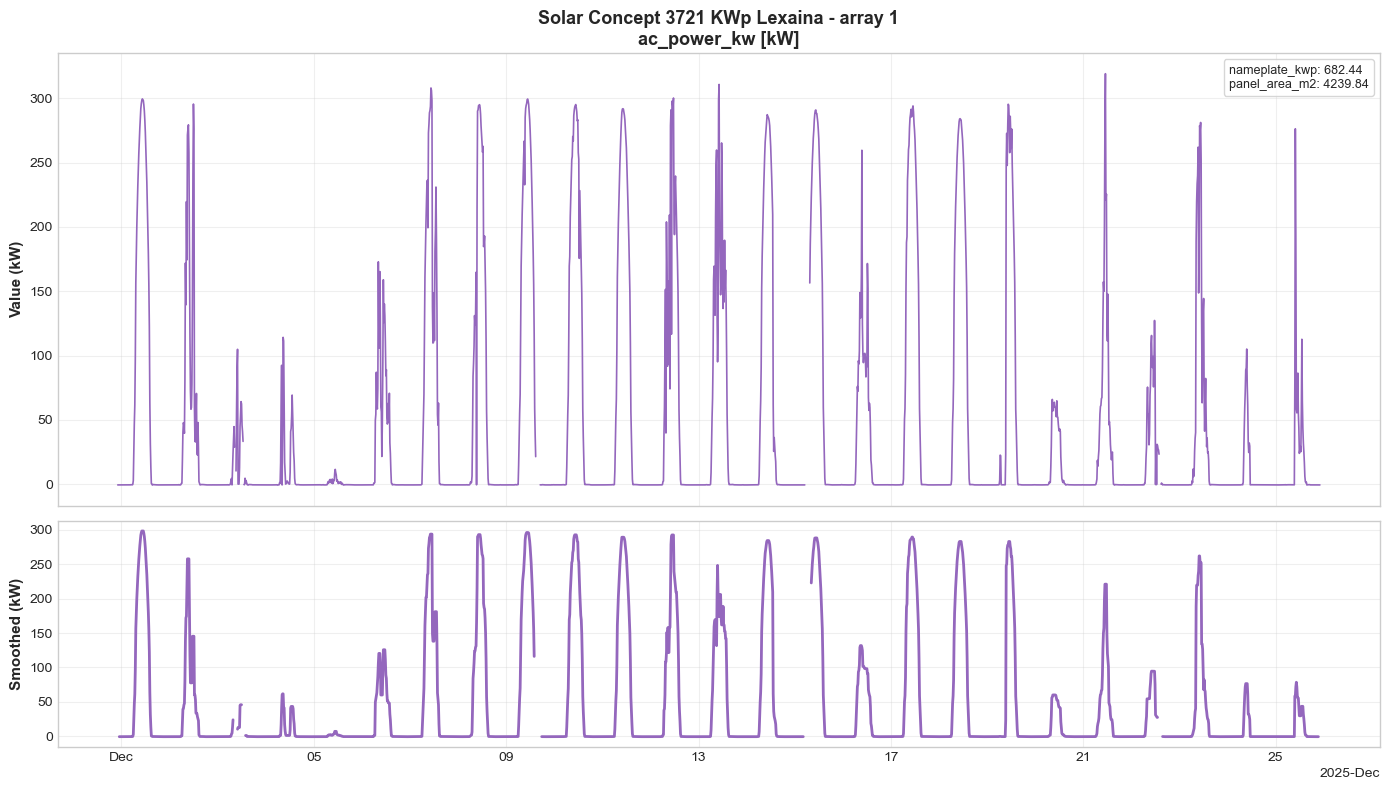

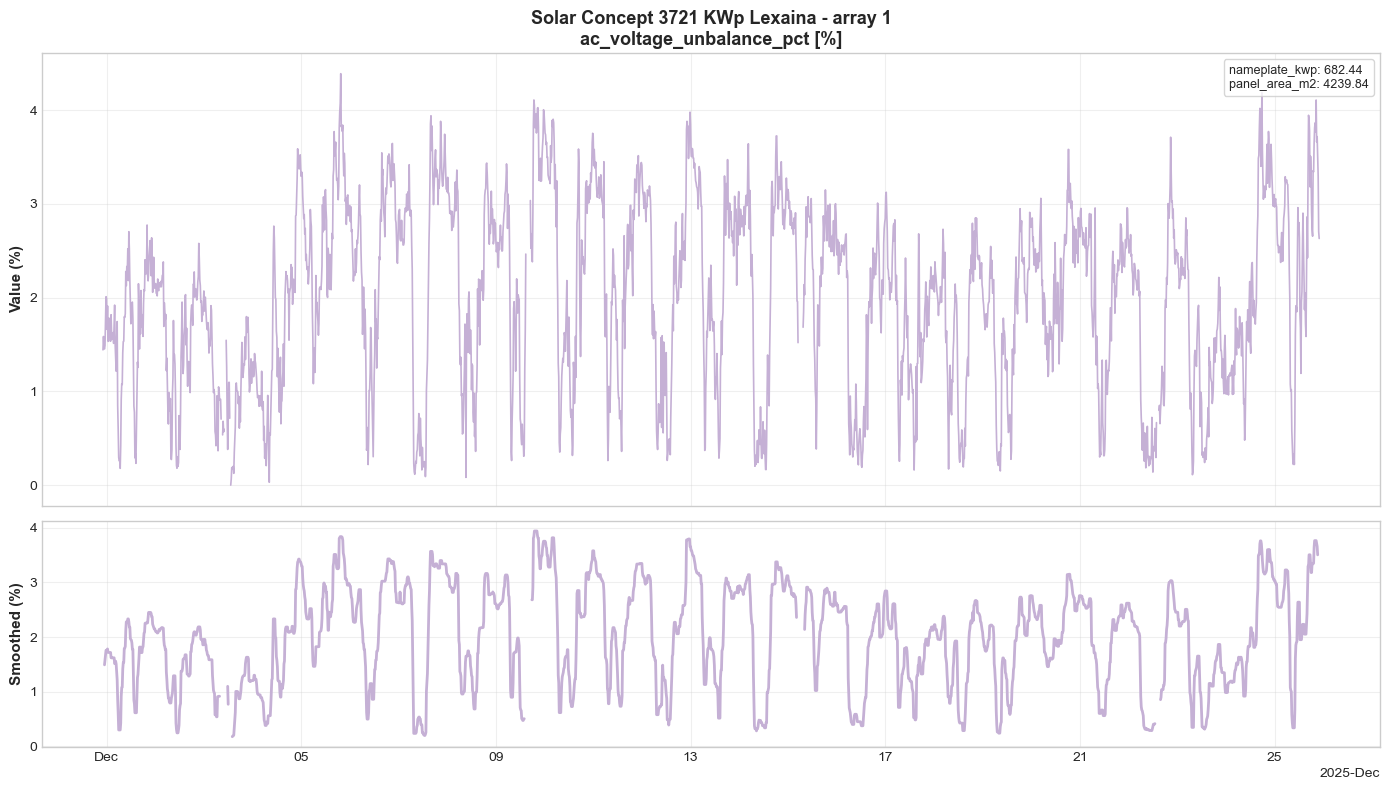

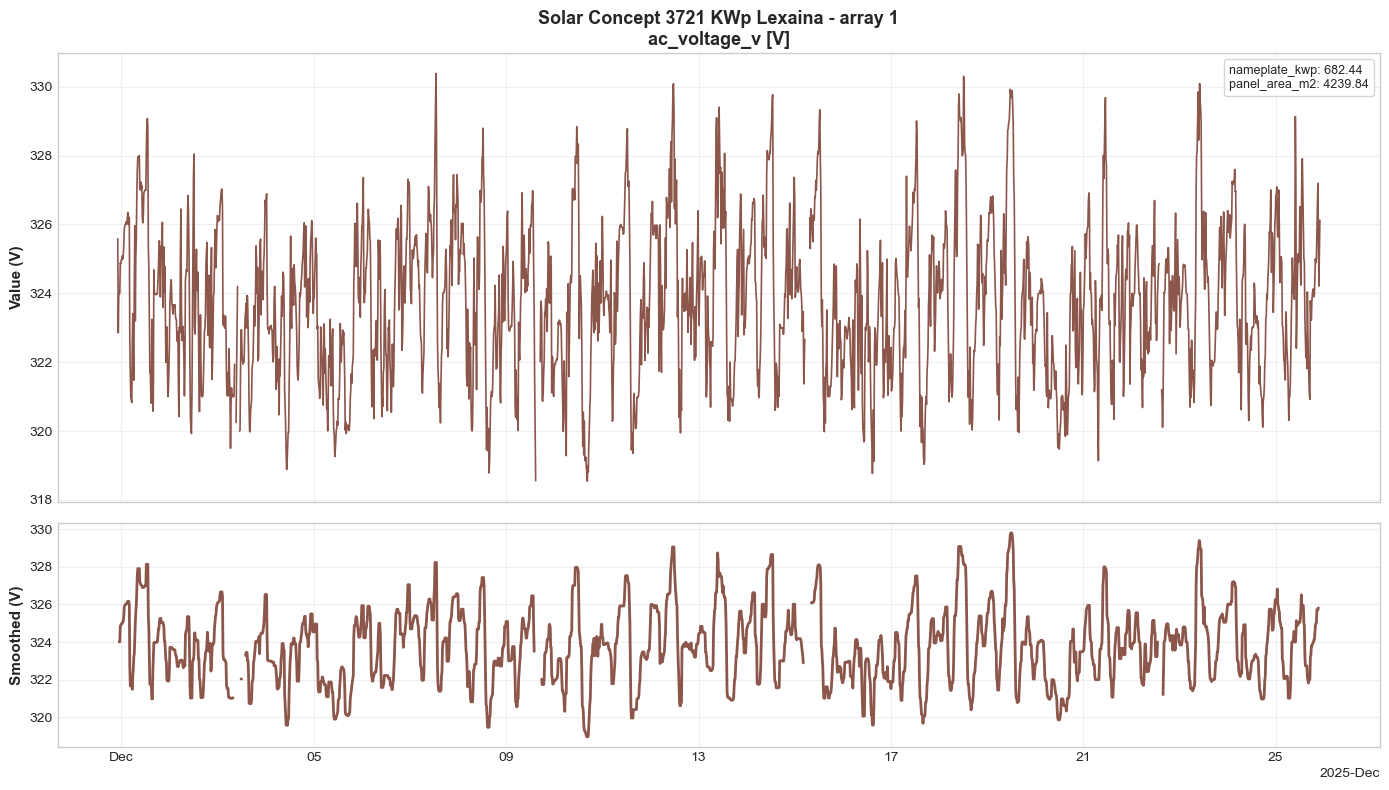

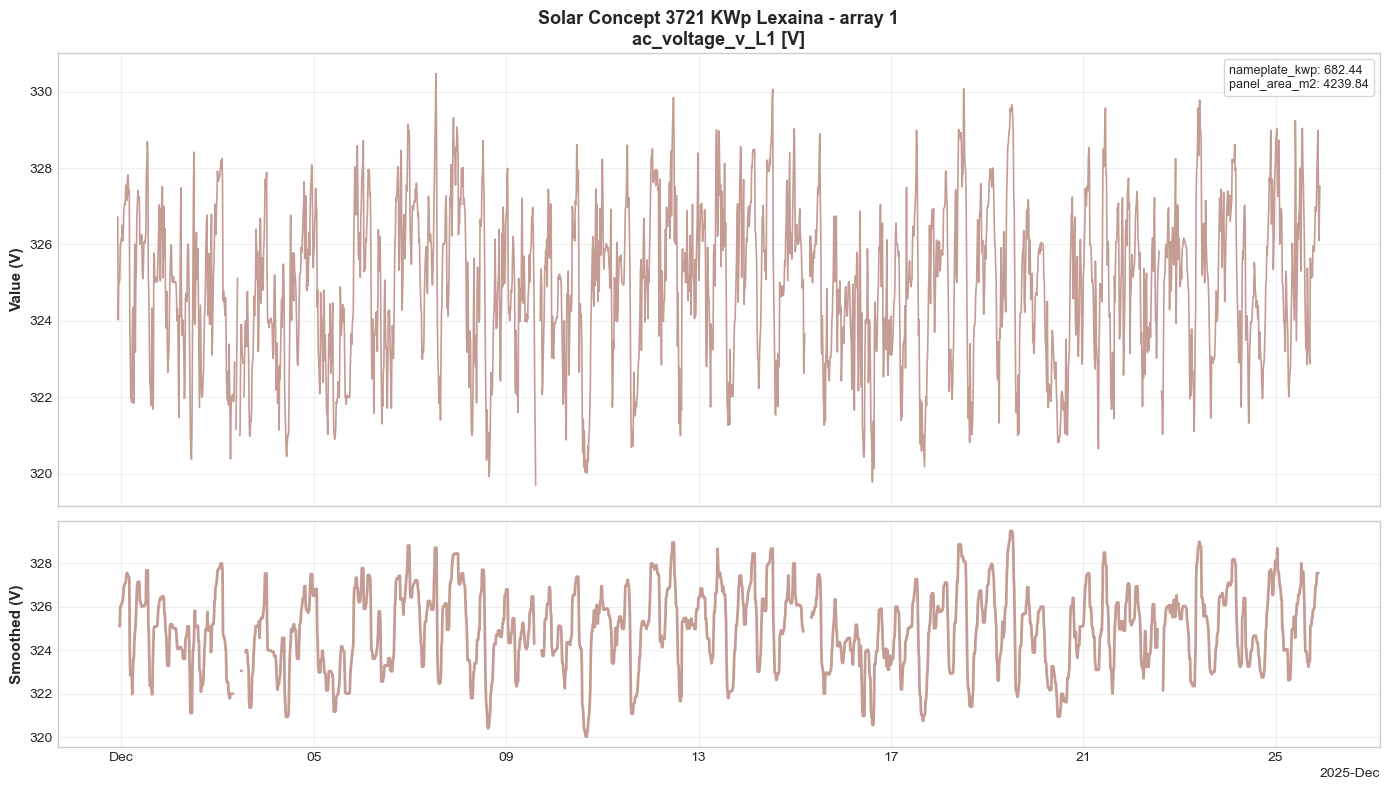

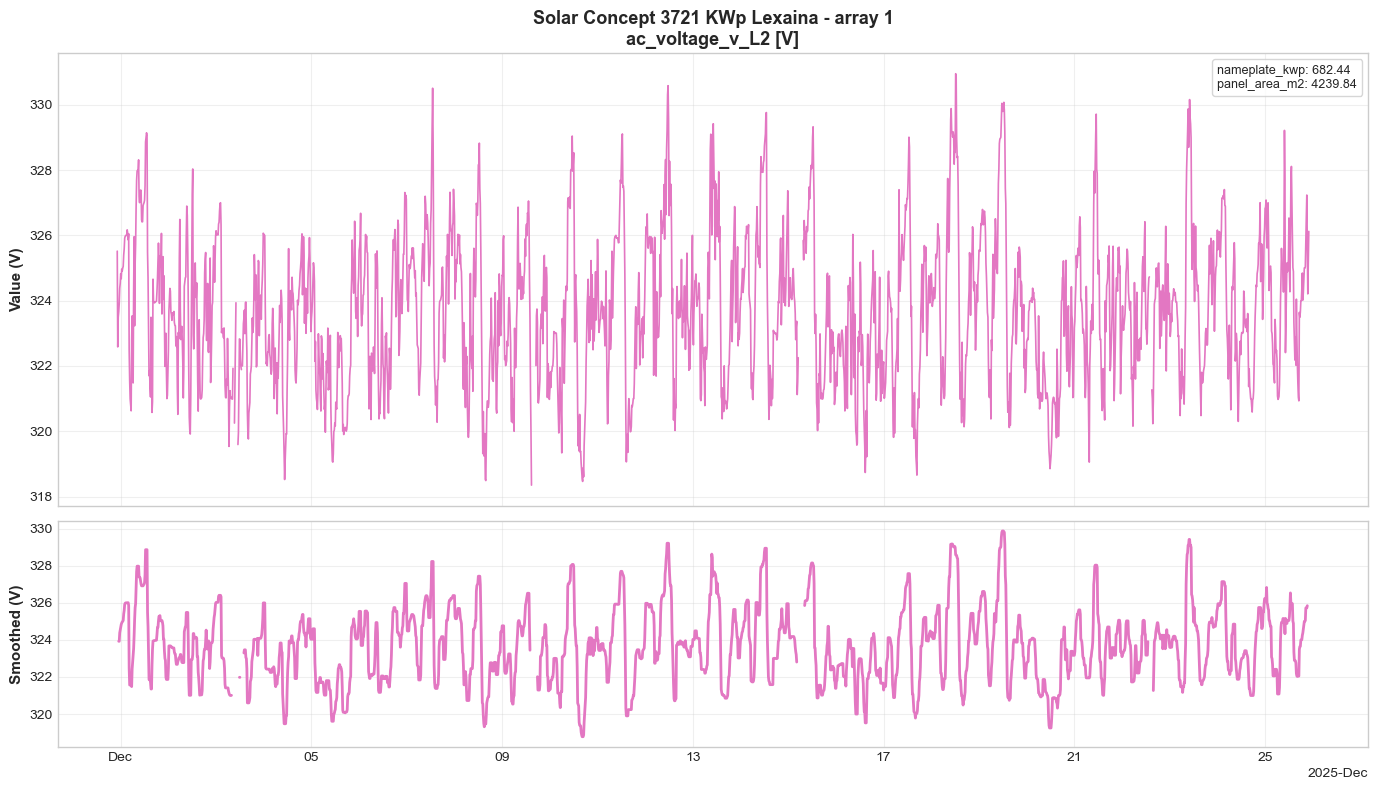

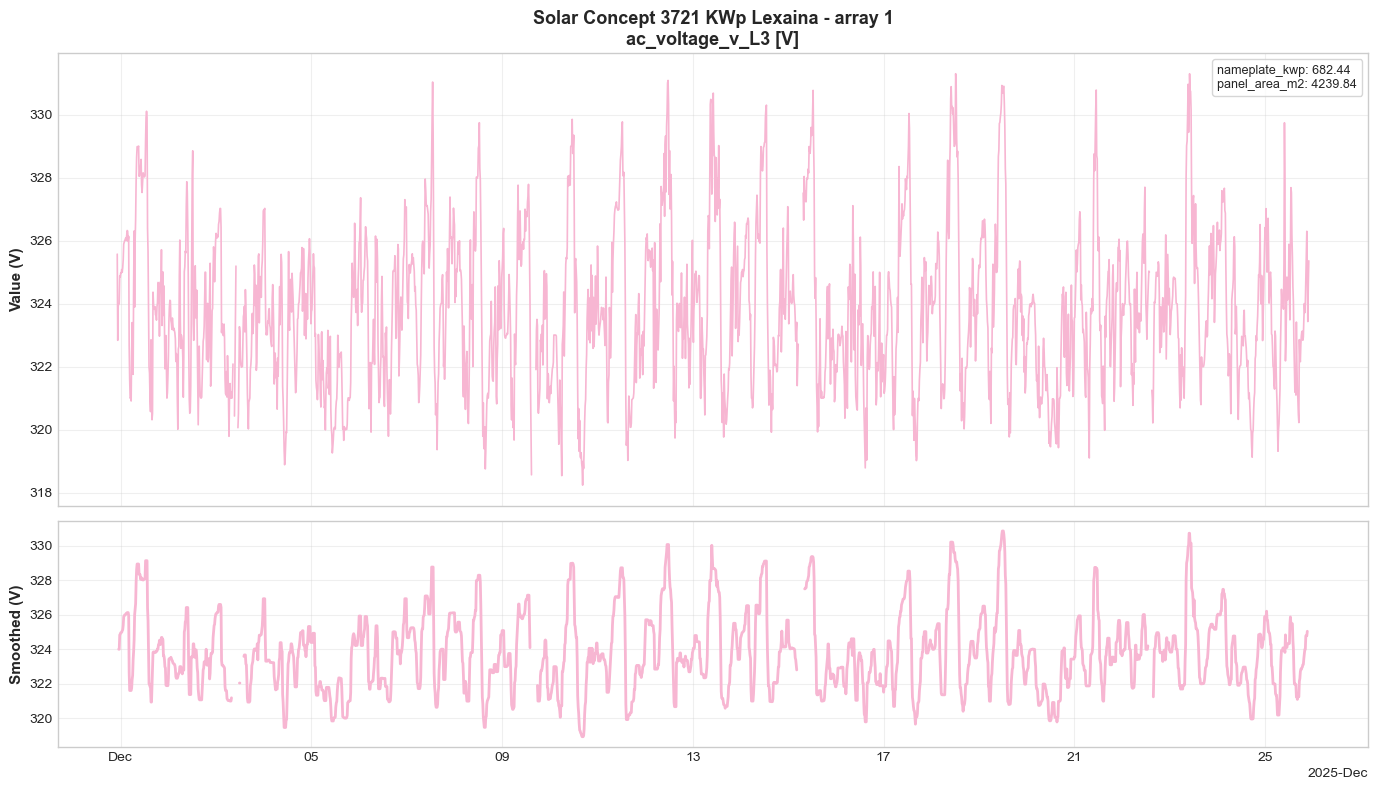

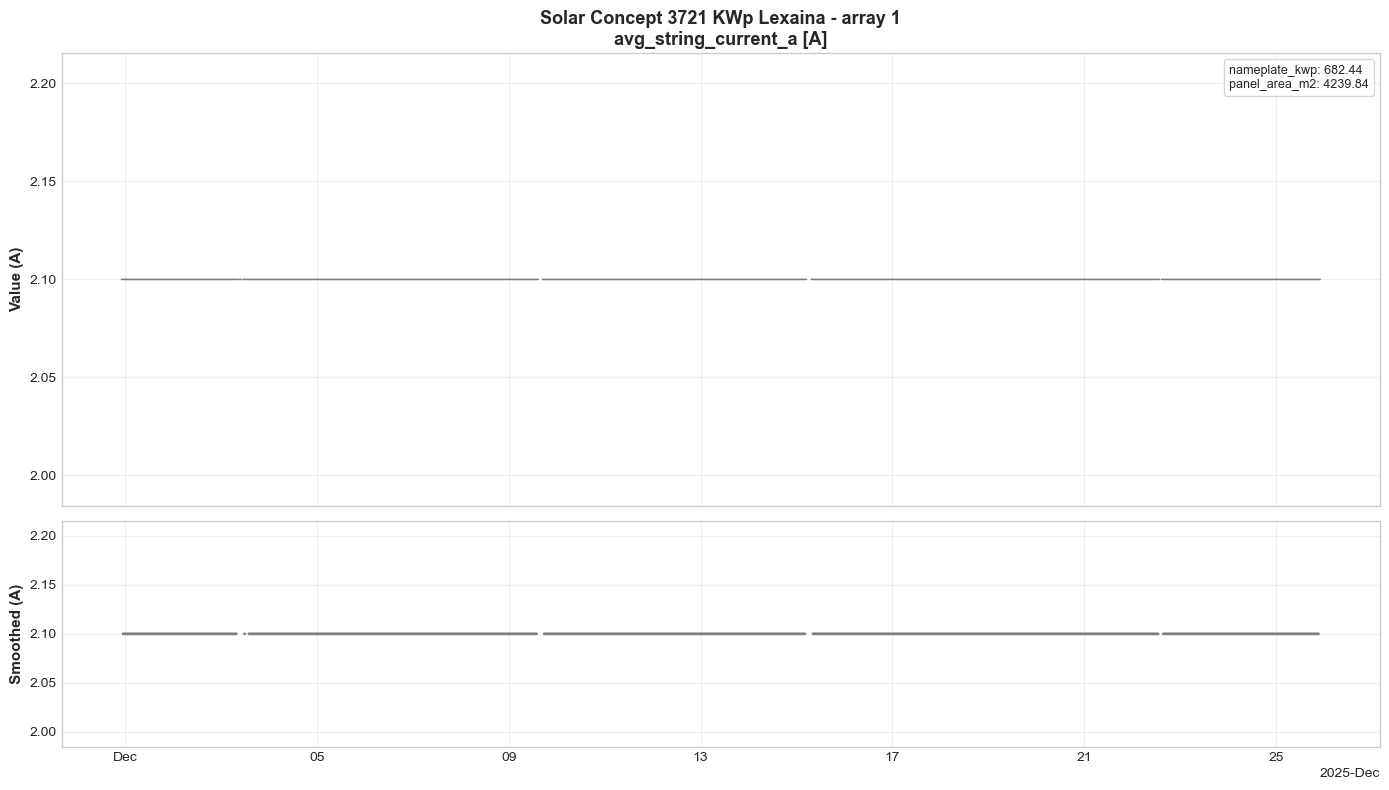

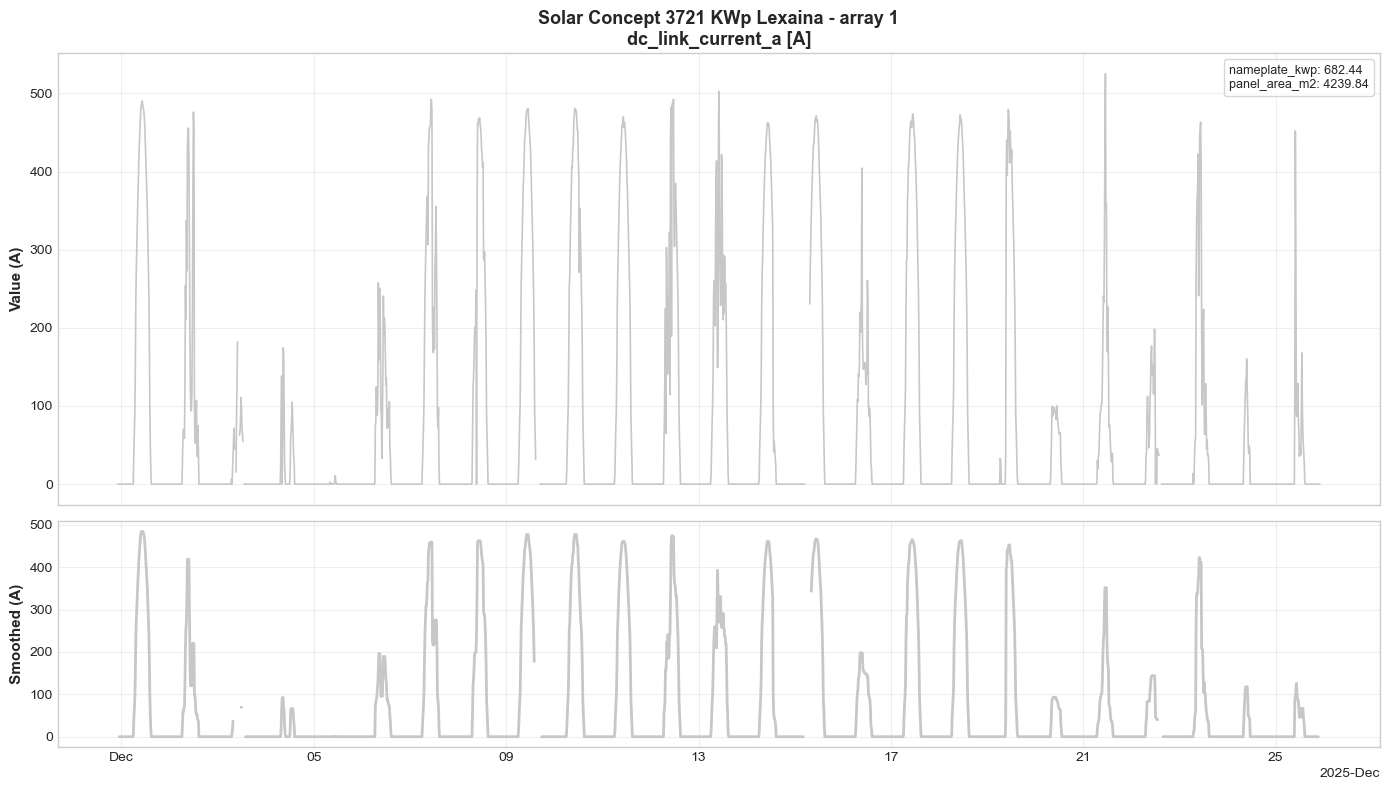

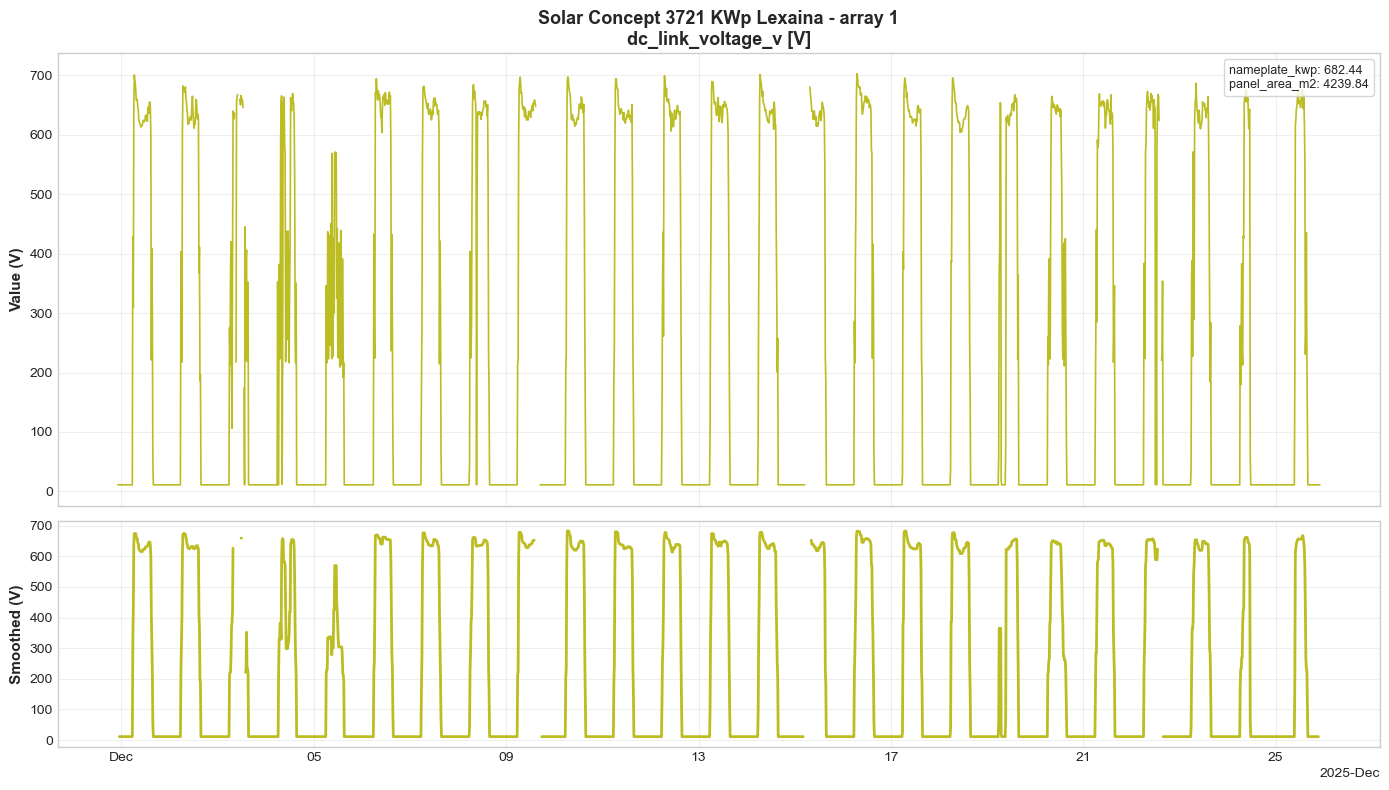

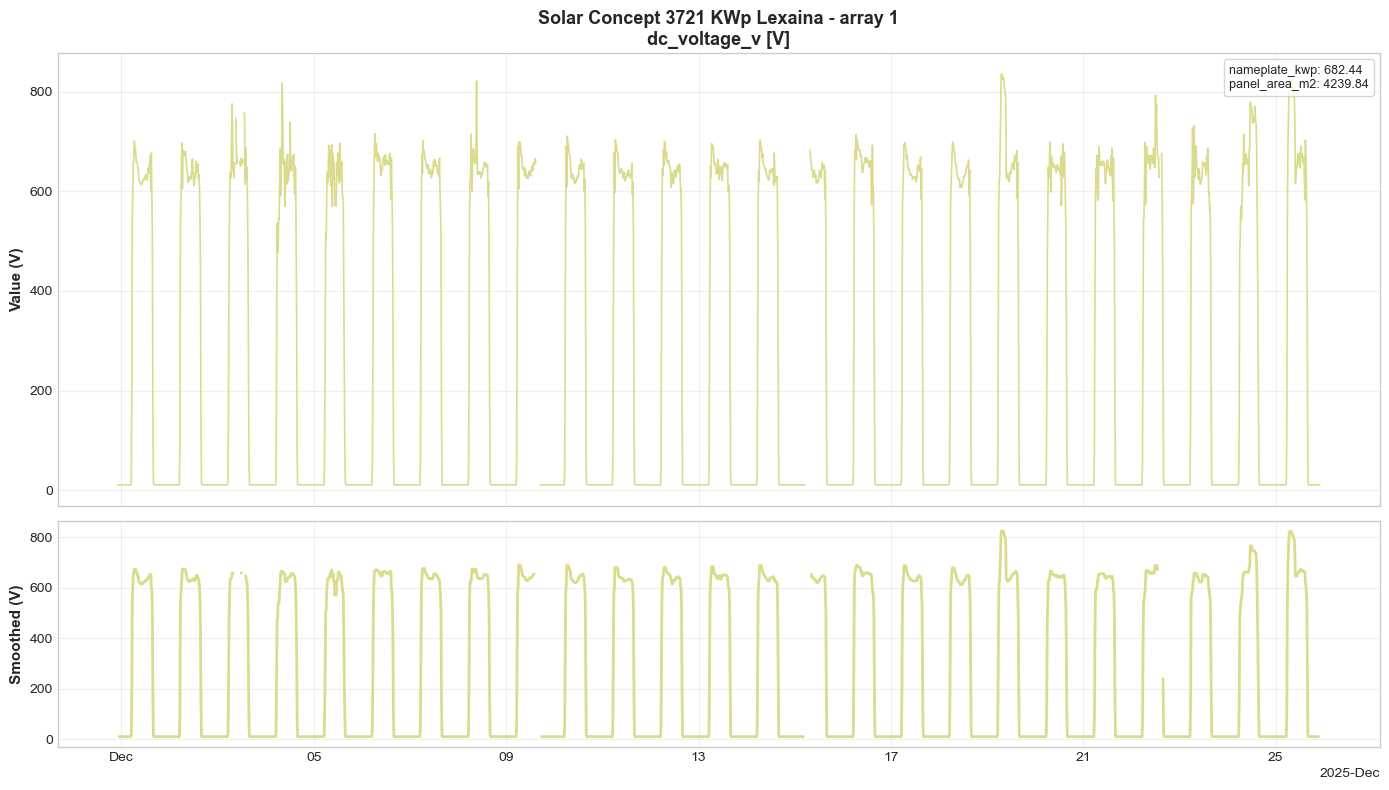

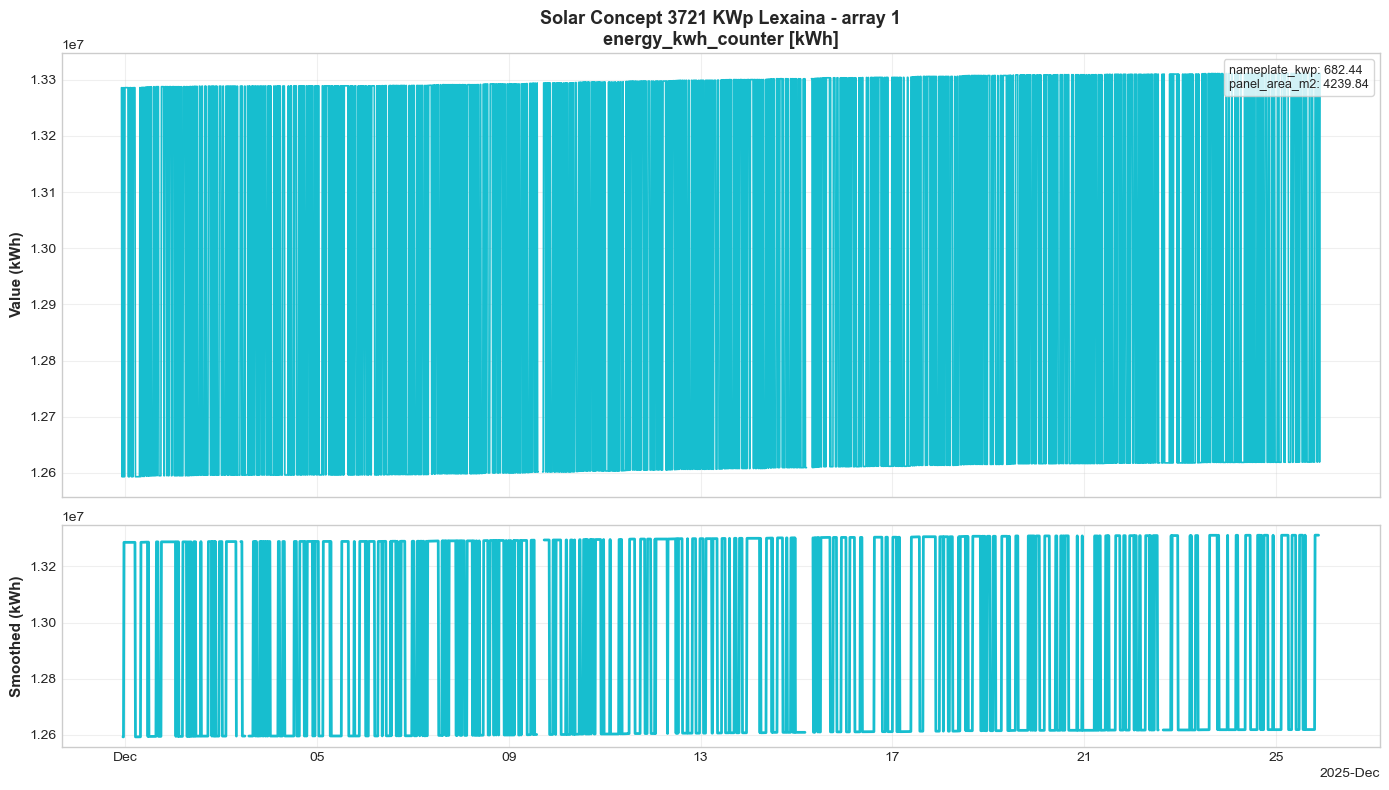

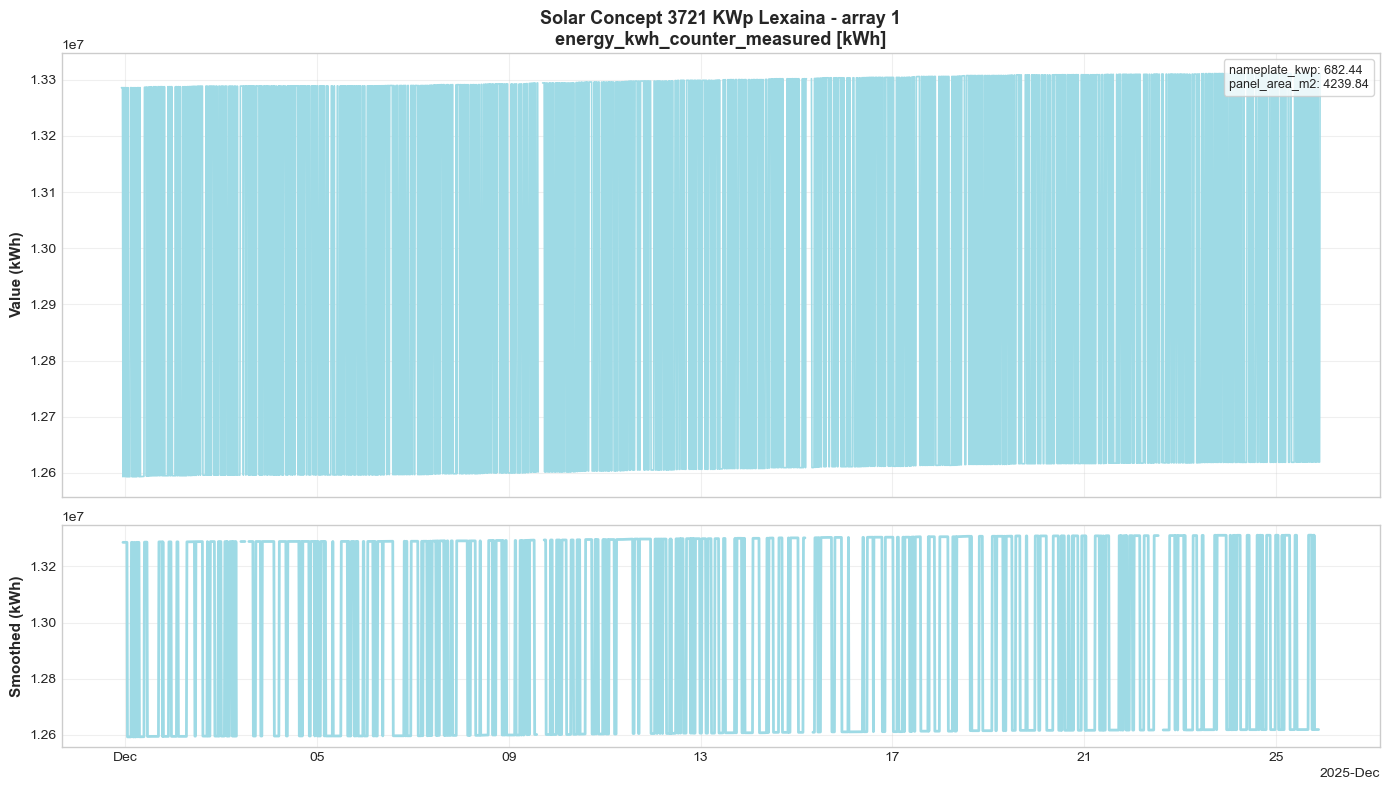

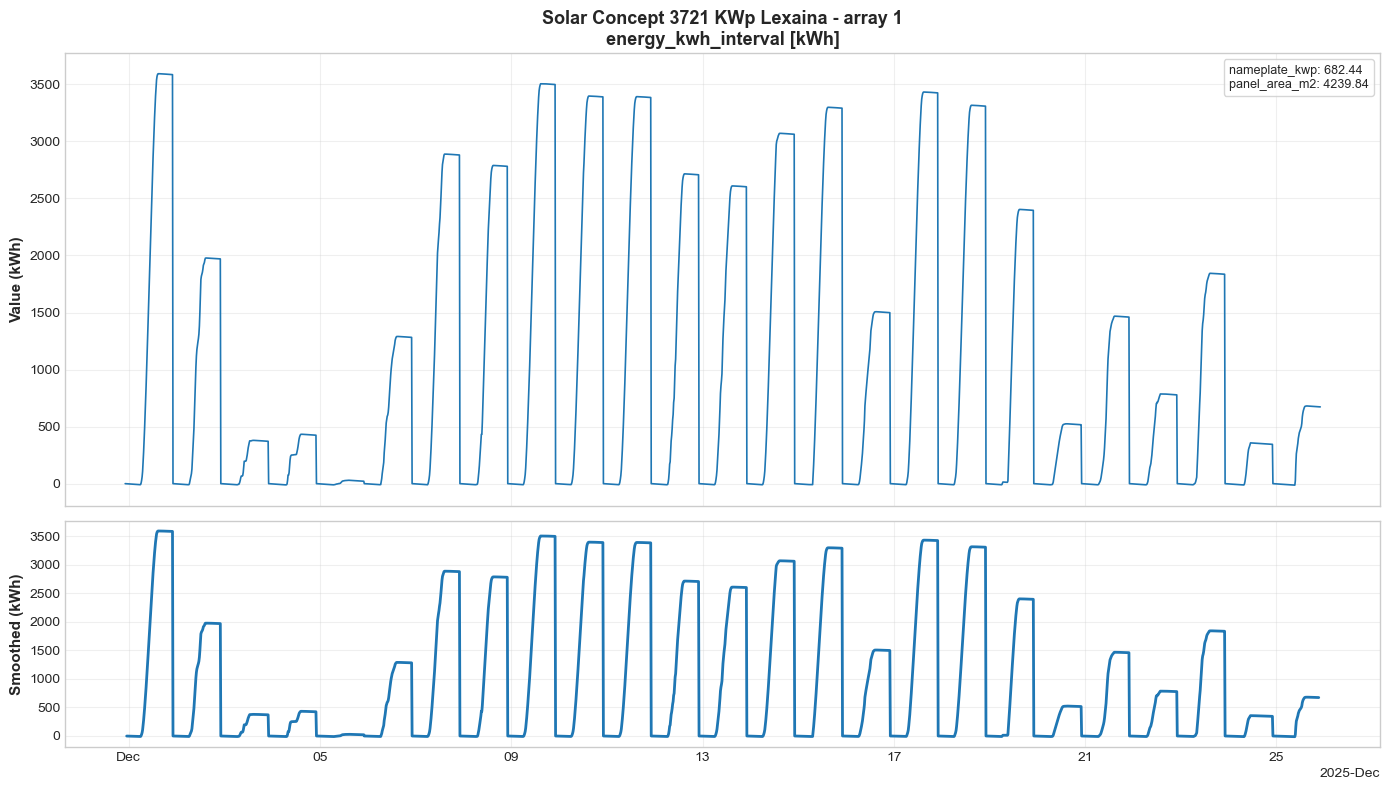

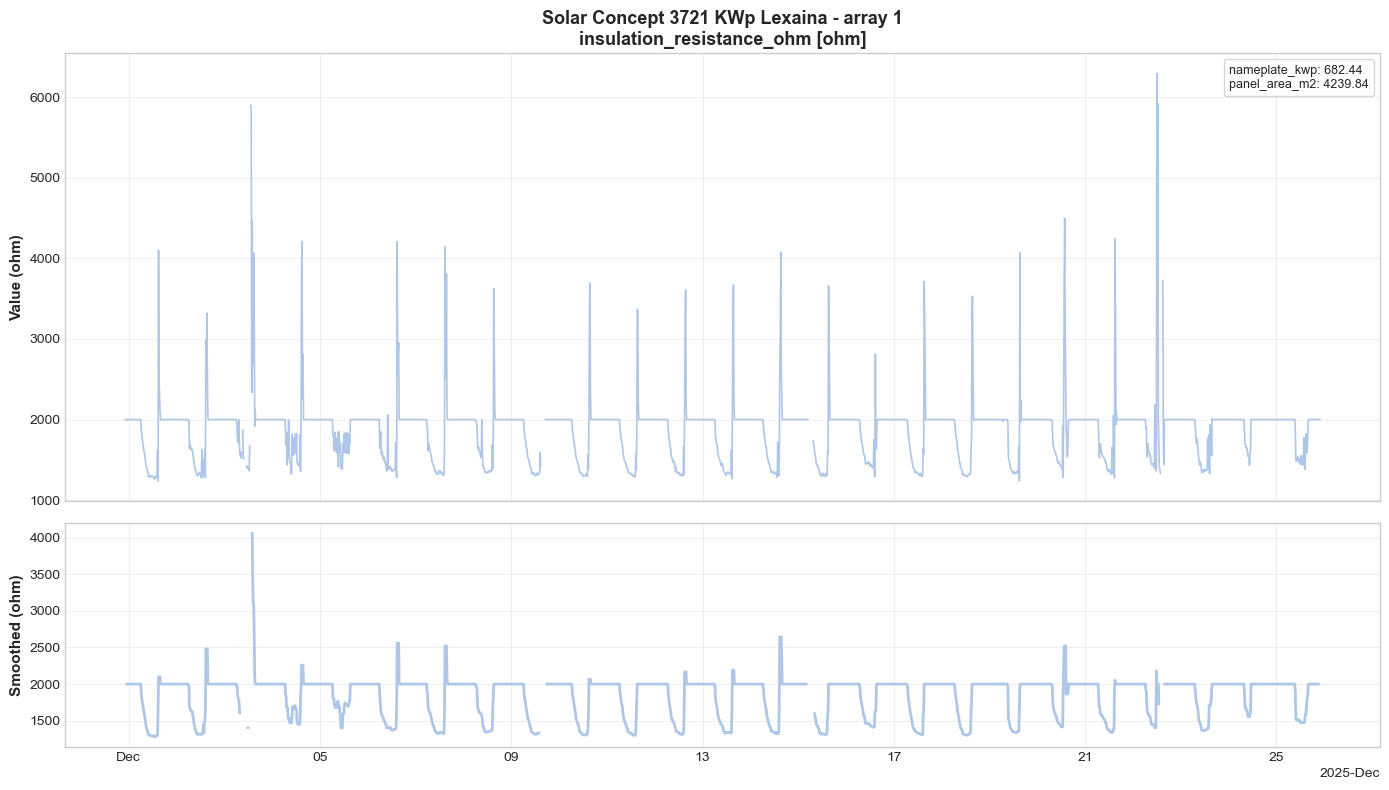

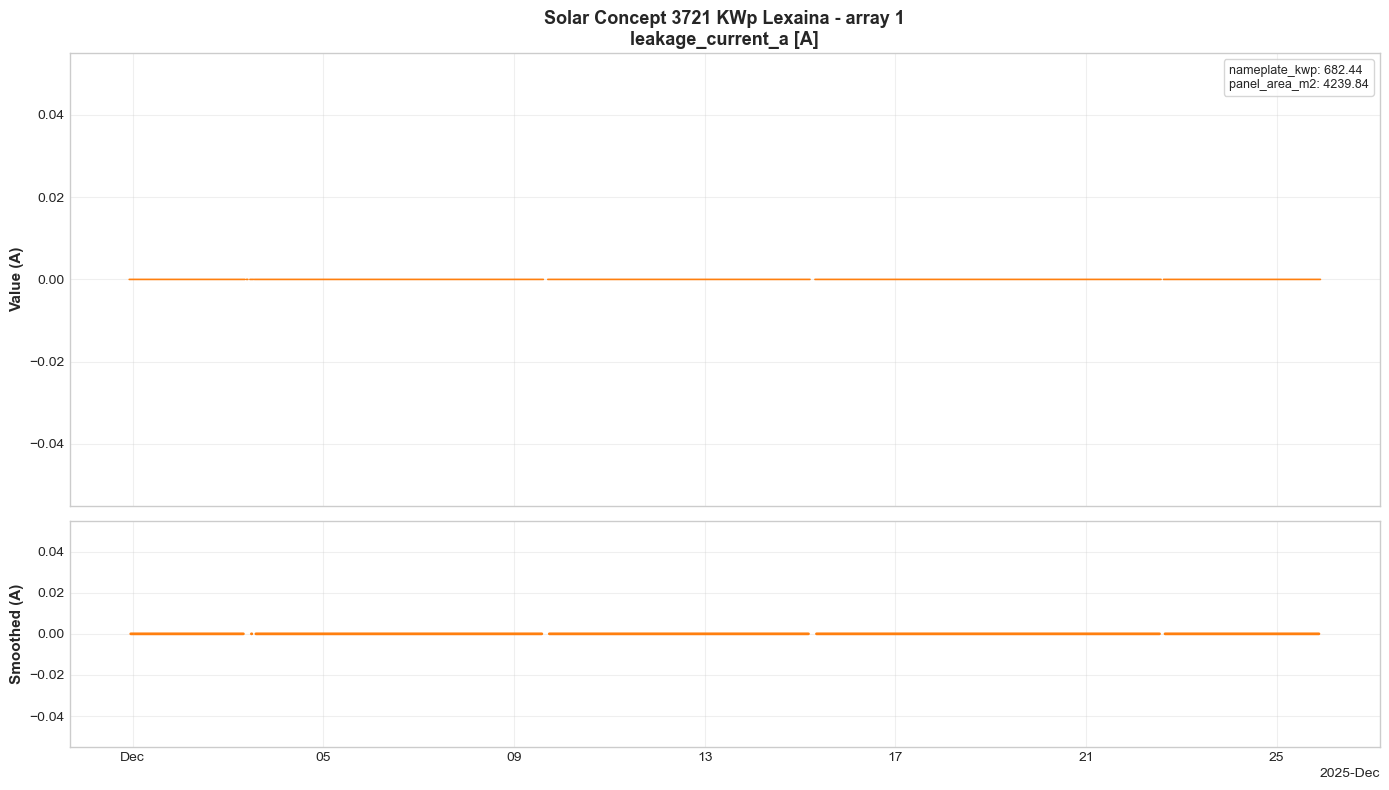

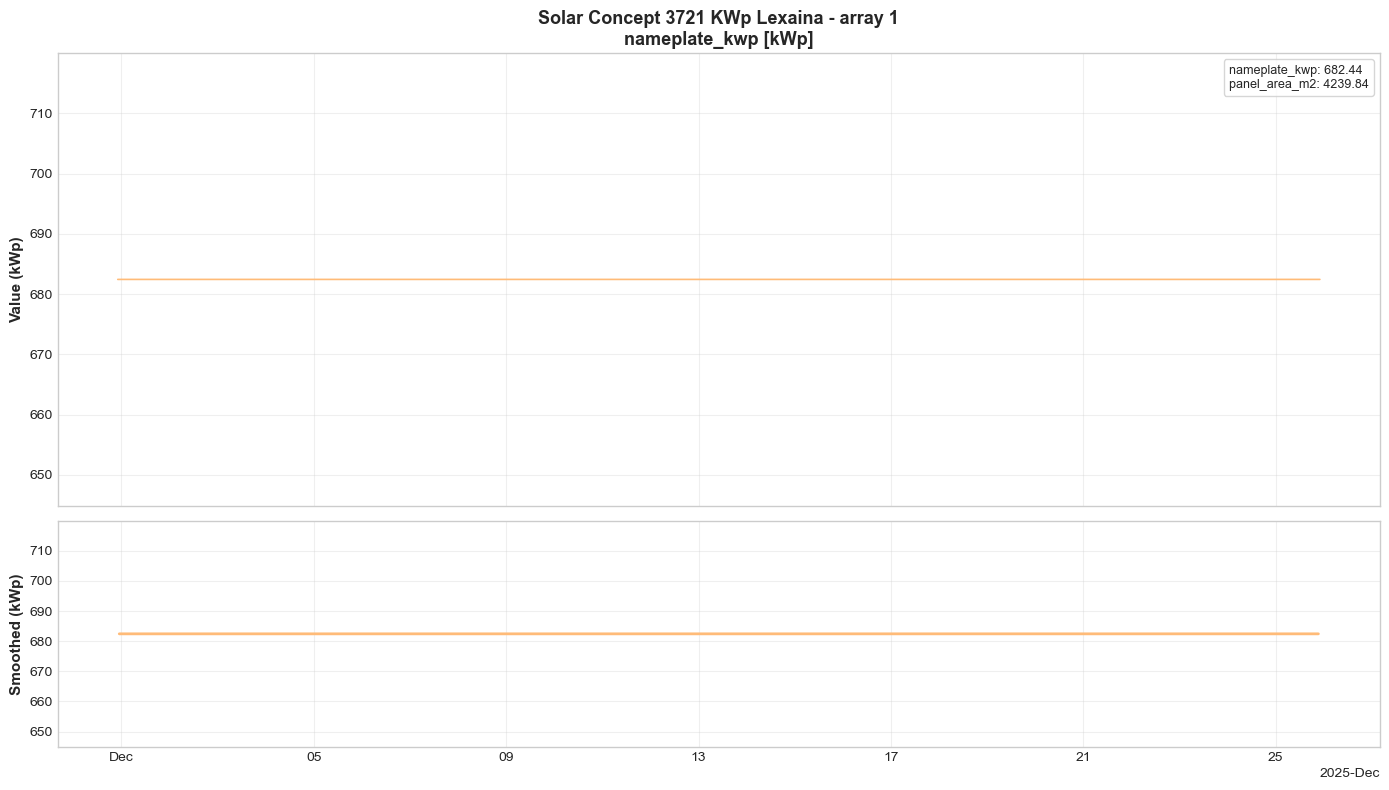

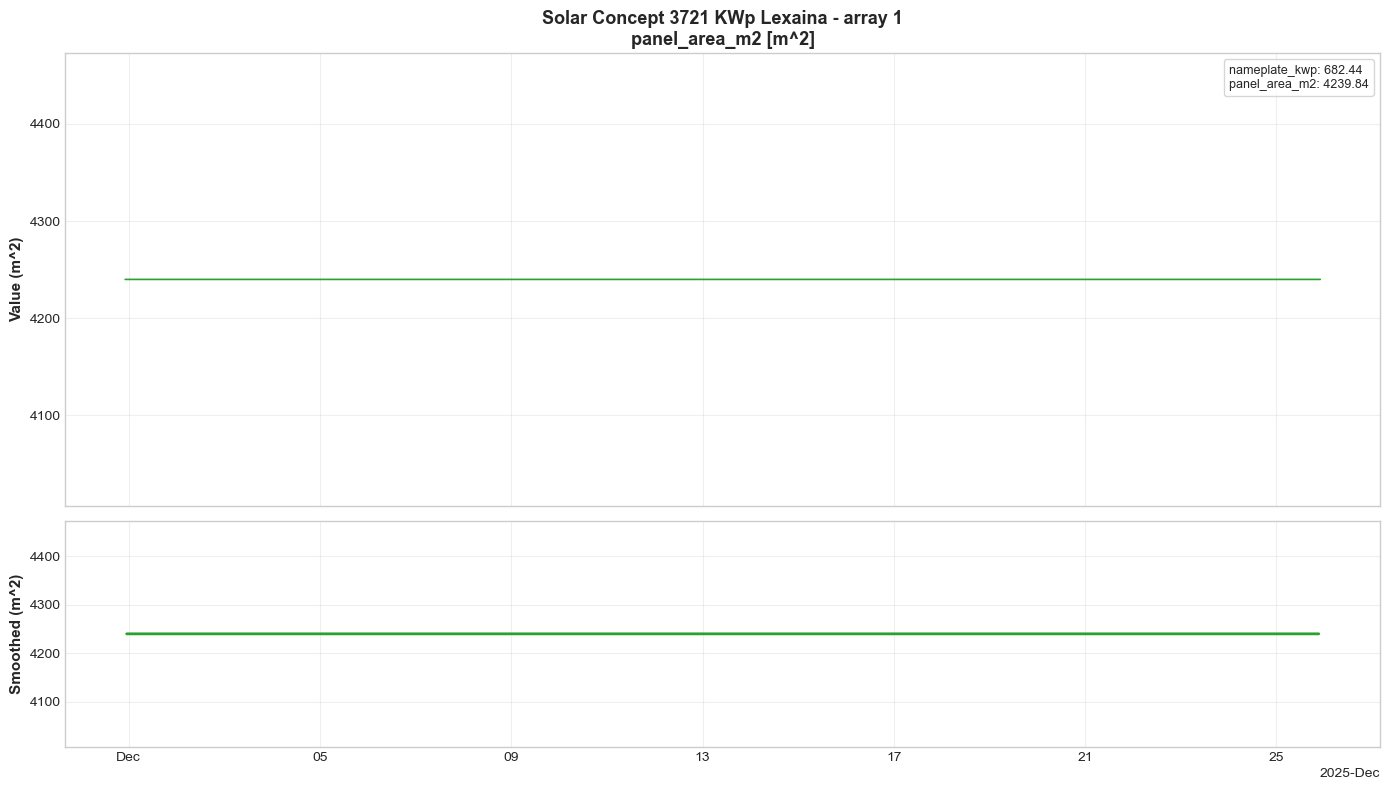

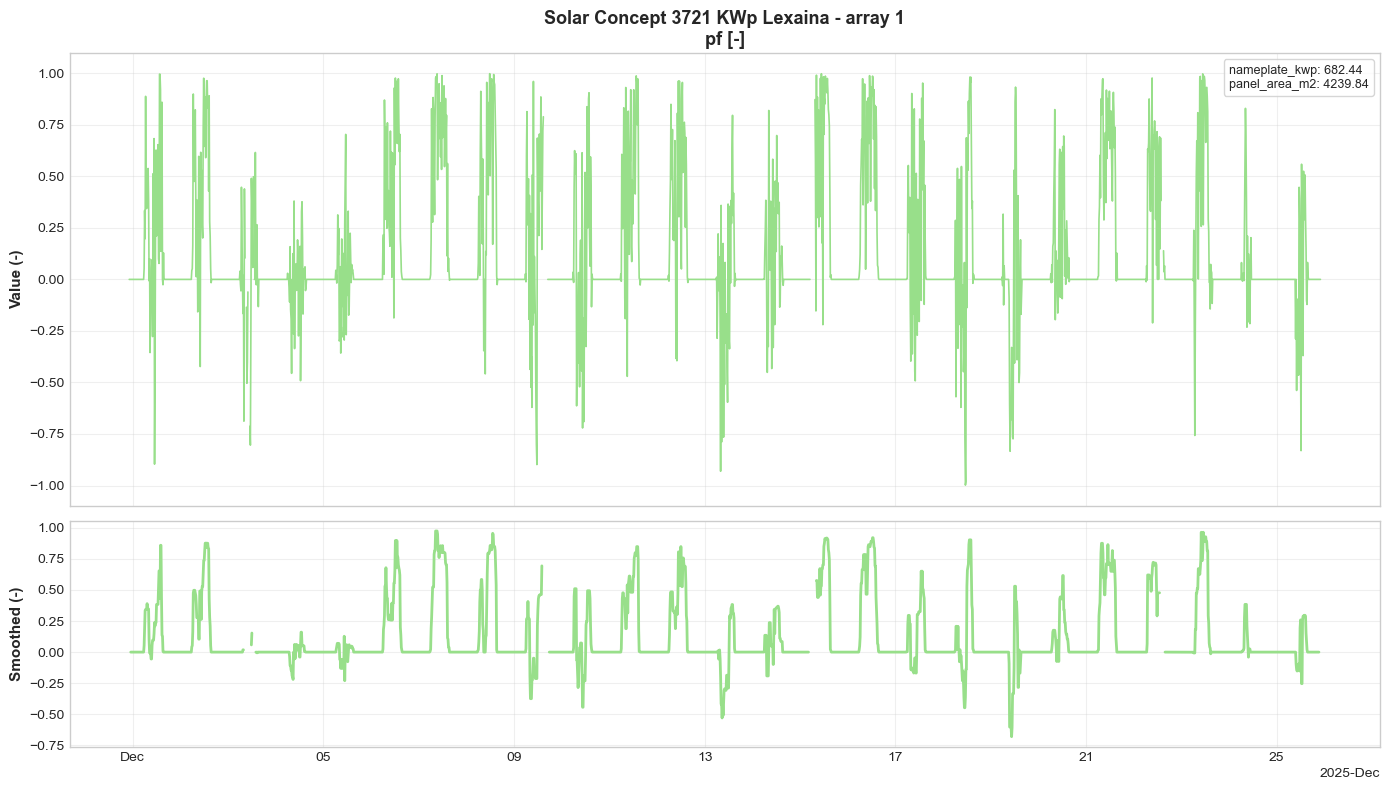

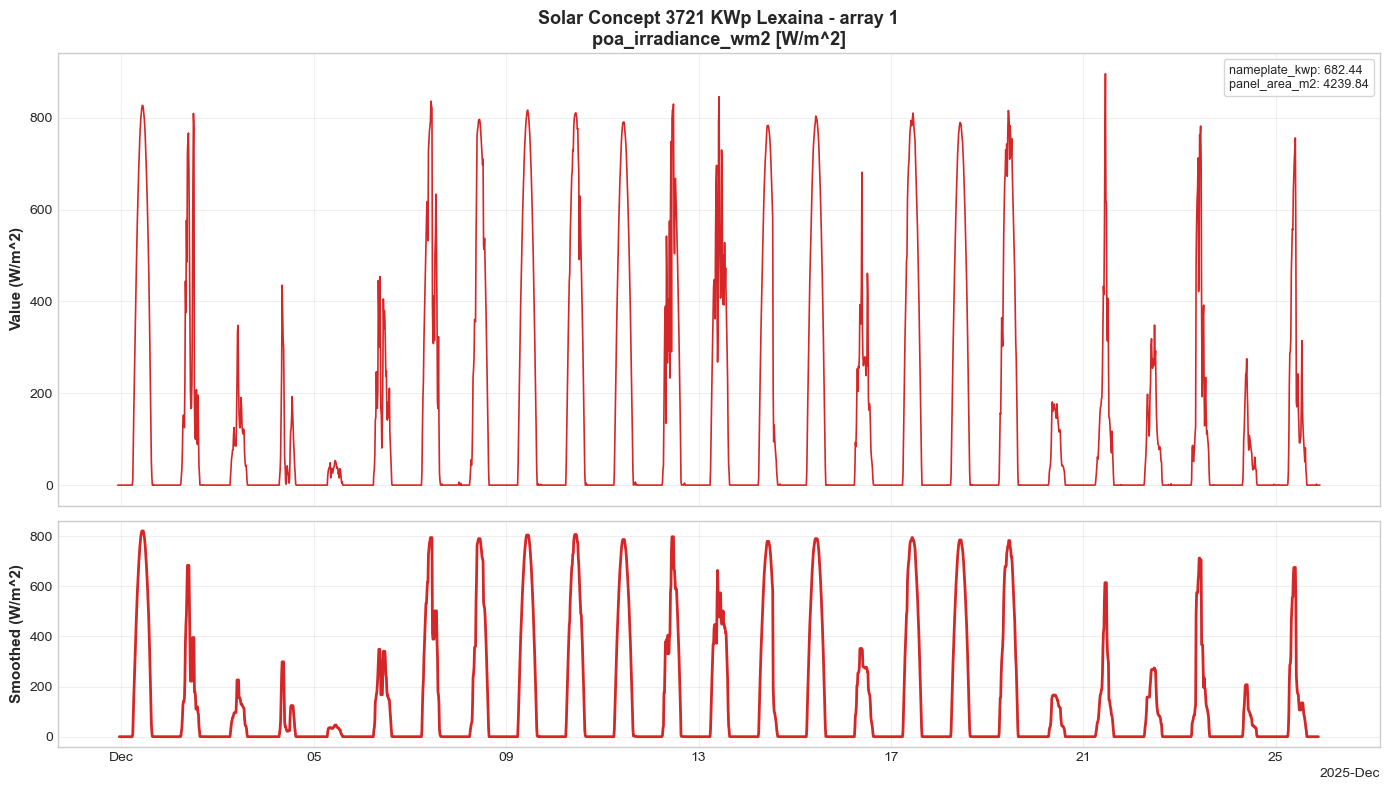

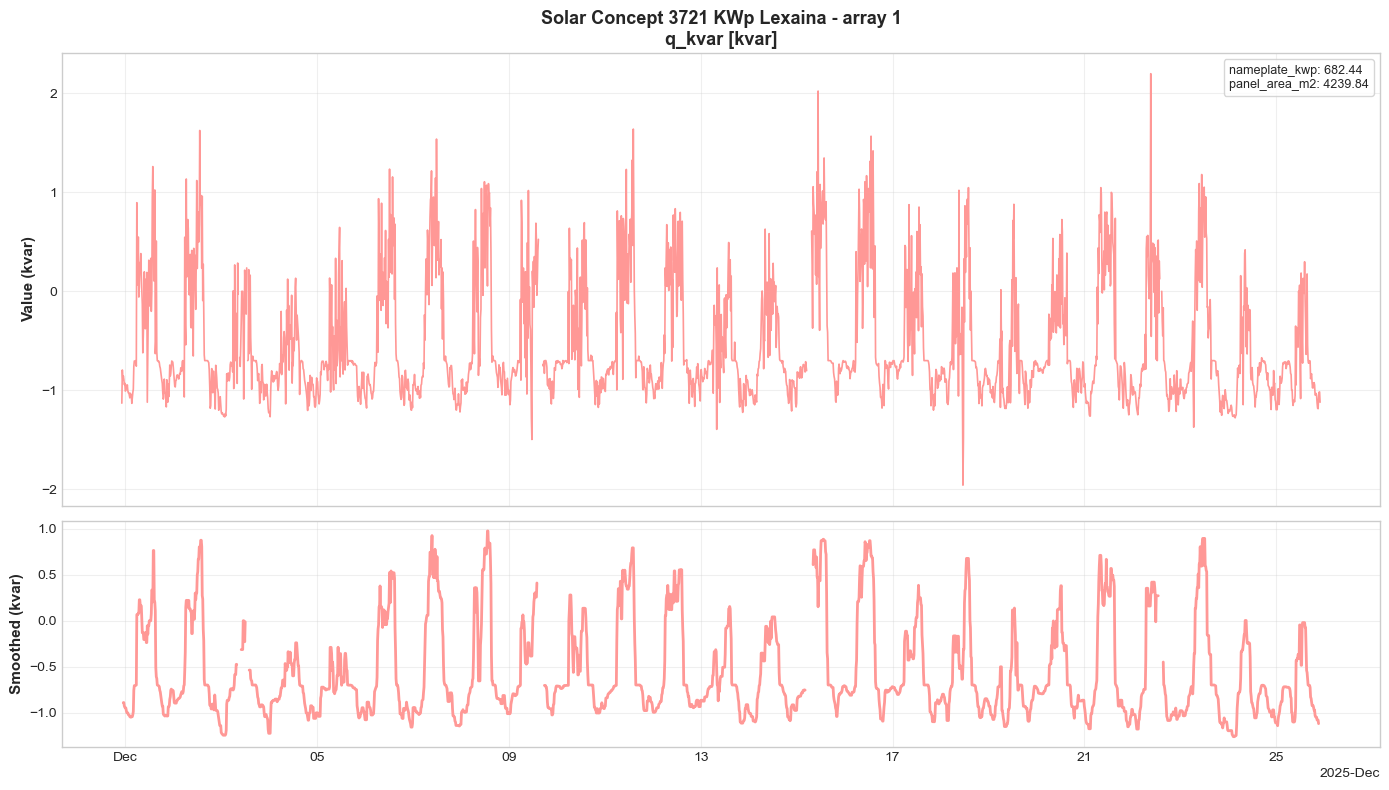

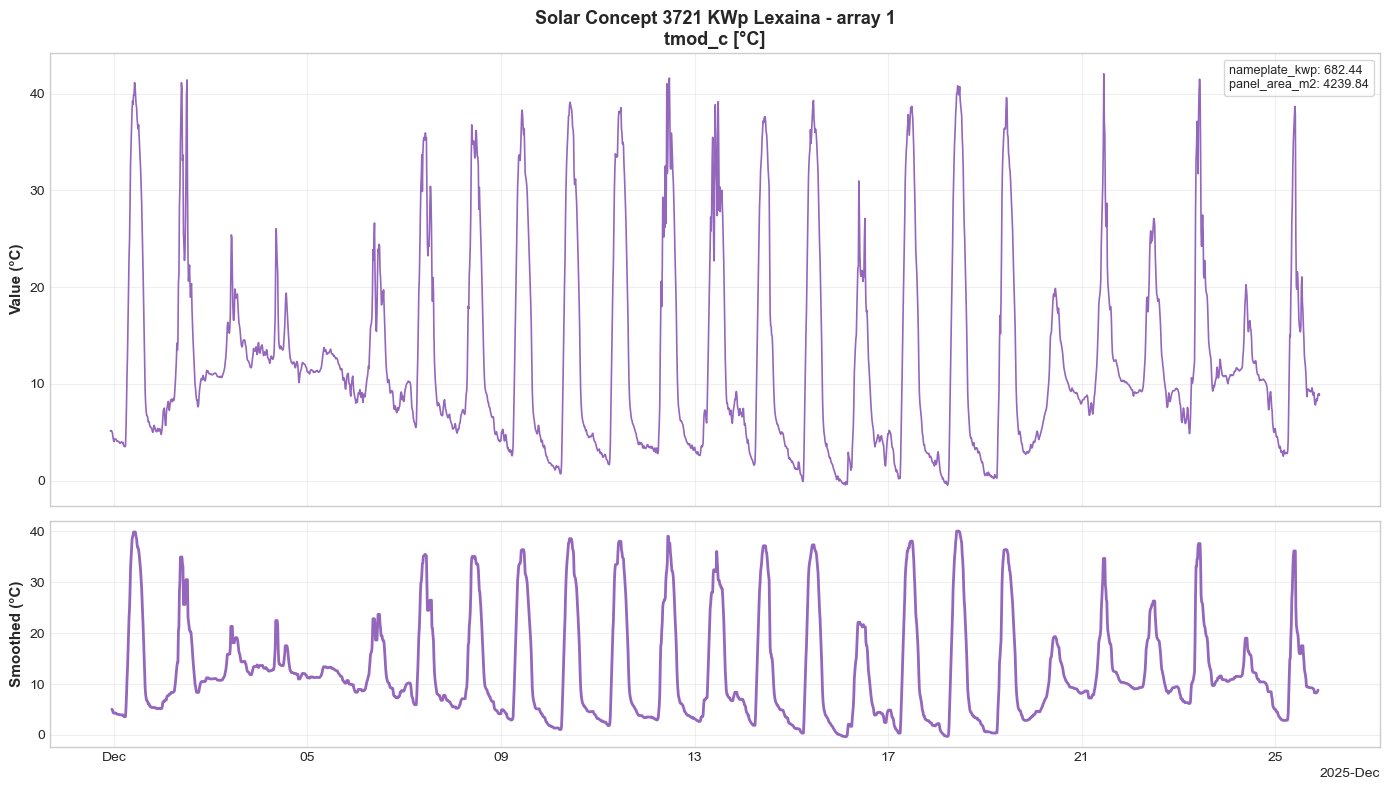

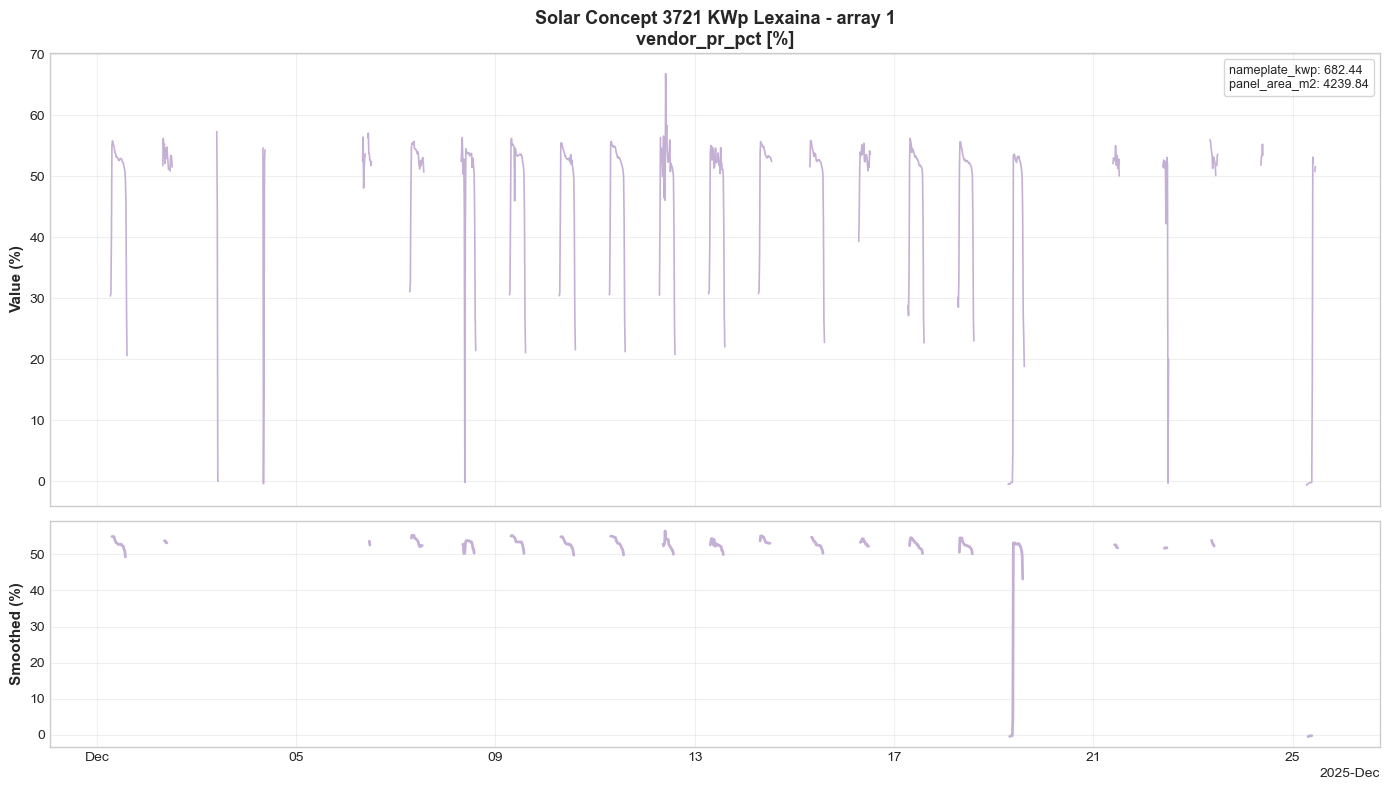

In [30]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd


def _extract_signal_value(df, signal_name):
    mask = df["canonical_signal"] == signal_name
    values = df.loc[mask, "value_rs"].dropna()
    if values.empty:
        return None
    return values.median()


def filter_scada_rs(scada_rs, plant_name, component_type, component_id, n=5):
    assert plant_name in scada_rs["plant_name"].unique(), "plant_name not found"

    keys = ["plant_name", "component_type", "component_id"]
    df = scada_rs.groupby(keys).get_group((plant_name, component_type, component_id)).copy()

    if "ts" in df.columns:
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        df = df.set_index("ts")
    else:
        df.index = pd.to_datetime(df.index, errors="coerce")

    assert df["plant_name"].nunique() == 1, "plant_name is not unique in filtered result"

    for col in ("nameplate_kwp", "panel_area_m2"):
        if col not in df.columns:
            value = _extract_signal_value(df, col)
            if value is not None:
                df[col] = value
        if col in df.columns:
            assert df[col].nunique() == 1, f"{col} is not unique in filtered result"

    print(df.head(n))
    print(df.columns)
    print(df["canonical_signal"].unique())
    return df


def plot_scada_signals(df, rolling_window=7):
    plt.style.use("seaborn-v0_8-whitegrid")

    required = ["value_rs", "canonical_signal", "unit"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    signals = sorted(df["canonical_signal"].unique())
    palette = plt.cm.tab20.colors
    color_map = {sig: palette[i % len(palette)] for i, sig in enumerate(signals)}

    for sig, grp in df.groupby("canonical_signal"):
        unit = grp["unit"].iloc[0]
        base_color = color_map[sig]
        meta = grp.iloc[0]

        fig, (ax1, ax2) = plt.subplots(
            2,
            1,
            figsize=(14, 8),
            sharex=True,
            gridspec_kw={"height_ratios": [2, 1]},
        )

        ax1.plot(grp.index, grp["value_rs"], linestyle="-", color=base_color, linewidth=1.2)
        ax1.set_title(
            f"{meta['plant_name']} - {meta['component_type']} {meta['component_id']}\n"
            f"{sig} [{unit}]",
            fontsize=13,
            weight="bold",
        )
        ax1.set_ylabel(f"Value ({unit})", fontsize=11, weight="bold")
        ax1.grid(True, alpha=0.3)

        rolling = grp["value_rs"].rolling(window=rolling_window, center=True).median()
        ax2.plot(grp.index, rolling, linestyle="-", color=base_color, linewidth=2)
        ax2.set_ylabel(f"Smoothed ({unit})", fontsize=11, weight="bold")
        ax2.grid(True, alpha=0.3)

        legend_text = (
            f"nameplate_kwp: {meta.get('nameplate_kwp', 'N/A')}\n"
            f"panel_area_m2: {meta.get('panel_area_m2', 'N/A')}"
        )
        ax1.legend(
            [legend_text],
            loc="upper right",
            frameon=True,
            fontsize=9,
            handlelength=0,
            handletextpad=0,
        )

        ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))

        plt.tight_layout()
        plt.show()


# Usage
df_filtered = filter_scada_rs(
    scada_rs,
    plant_name="Solar Concept 3721 KWp Lexaina",
    component_type="array",
    component_id="1",
)

plot_scada_signals(df_filtered, rolling_window=7)

Early EDA (mandatory)

We validate:

missingness for key signals

histograms for POA/Tmod/Power

power vs irradiance sanity scatter (single debug plant)

plant_name               signal      n  missing_frac
0  Solar Concept 3721 KWp Lexaina          ac_power_kw  21600      0.229954
1  Solar Concept 3721 KWp Lexaina   poa_irradiance_wm2  21600      0.000000
2  Solar Concept 3721 KWp Lexaina               tmod_c  21600      0.000000
3  Solar Concept 3721 KWp Lexaina  energy_kwh_interval  21600      0.666667

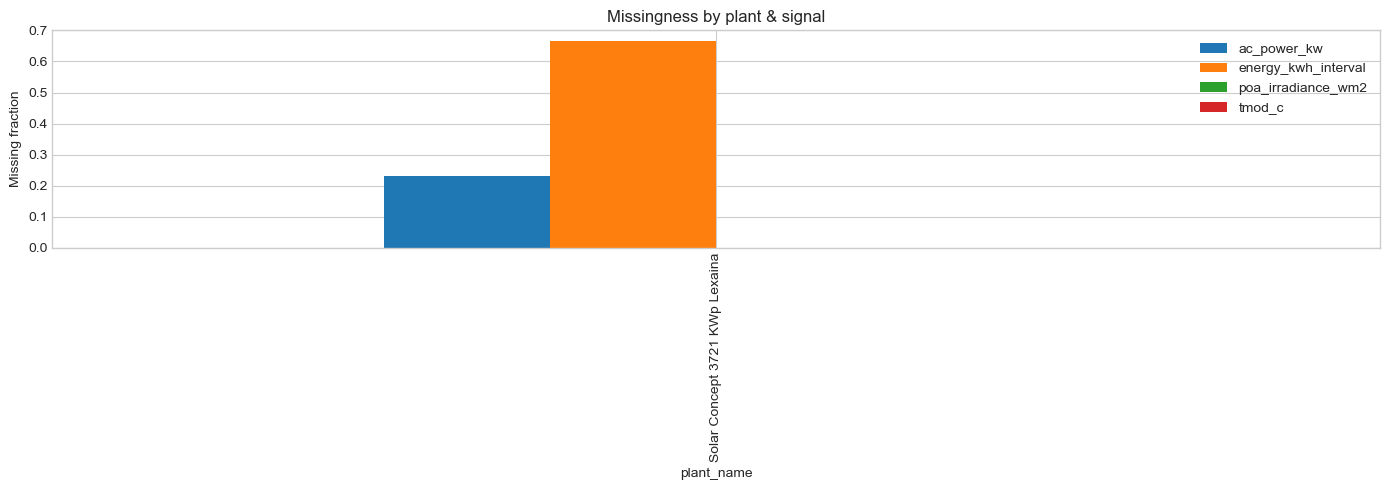

In [39]:
KEY_SIGNALS = ["ac_power_kw", "poa_irradiance_wm2", "tmod_c", "energy_kwh_interval"]


def missingness_by_plant(scada_rs: pd.DataFrame):
    out = []
    for plant, g in scada_rs.groupby("plant_name"):
        for sig in KEY_SIGNALS:
            gg = g[g["canonical_signal"] == sig]
            out.append(
                {
                    "plant_name": plant,
                    "signal": sig,
                    "n": int(len(gg)),
                    "missing_frac": float(gg["value_rs"].isna().mean()) if len(gg) else 1.0,
                }
            )
    return pd.DataFrame(out)


miss = missingness_by_plant(scada_rs)
display(miss.head(10))
plot_missingness_bars(miss)

In [40]:
# Pick a debug plant (first plant)
plants = sorted(scada_rs["plant_name"].dropna().unique().tolist())
DEBUG_PLANT = cfg.selected_plant or (plants[0] if plants else None)
print("DEBUG_PLANT:", DEBUG_PLANT)

sub = scada_rs[scada_rs["plant_name"] == DEBUG_PLANT]

poa = sub[sub["canonical_signal"] == "poa_irradiance_wm2"].groupby("ts")["value_rs"].median()
tmod = sub[sub["canonical_signal"] == "tmod_c"].groupby("ts")["value_rs"].median()
pwr = sub[sub["canonical_signal"] == "ac_power_kw"].groupby("ts")["value_rs"].sum(min_count=1)

print("Series points:", len(poa), len(tmod), len(pwr))
print("POA stats:", poa.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_dict())
print("Power stats:", pwr.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_dict())

DEBUG_PLANT: Solar Concept 3721 KWp Lexaina
Series points: 2400 2400 2400
POA stats: {'count': 2400.0, 'mean': 132.79528909588876, 'std': 237.06466742345754, 'min': 0.0, '1%': 0.0, '5%': 0.0, '50%': 0.0, '95%': 742.57050655, '99%': 806.3383840099999, 'max': 895.823303}
Power stats: {'count': 2379.0, 'mean': 376.6194909791671, 'std': 722.6262282015938, 'min': -6.553499835, '1%': -5.7991386932, '5%': -5.5065052866, '50%': -4.735666603, '95%': 2282.7215749999996, '99%': 2470.2948075099994, 'max': 2644.491677}


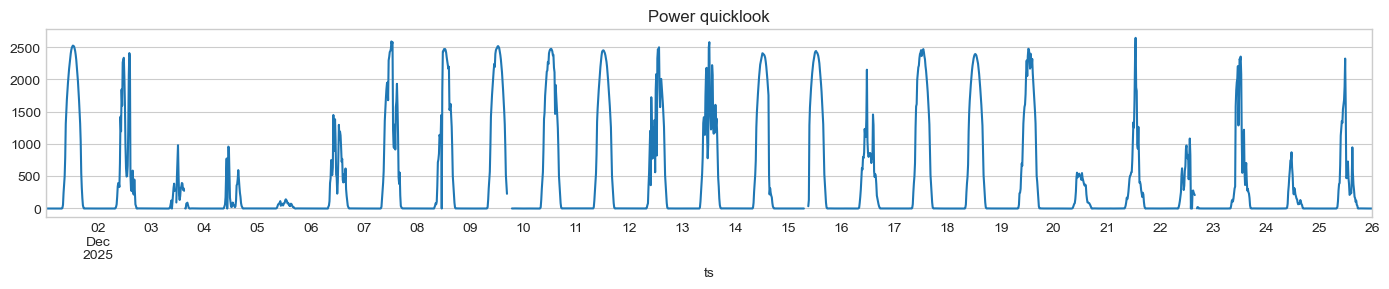

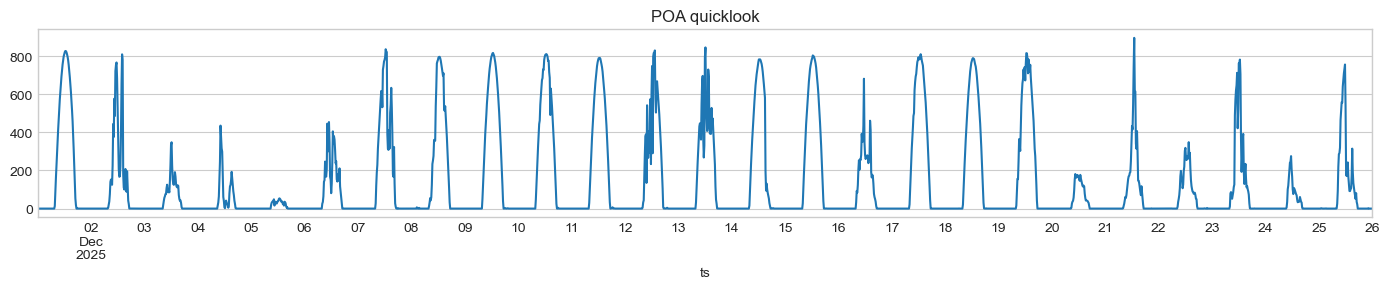

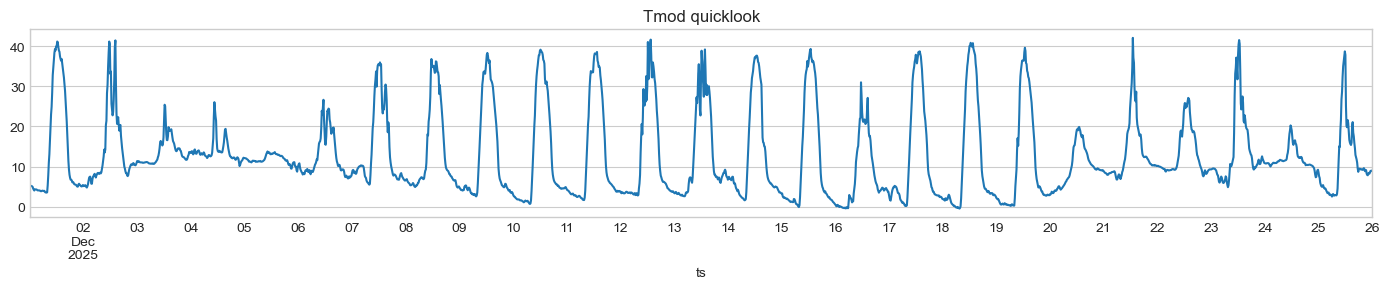

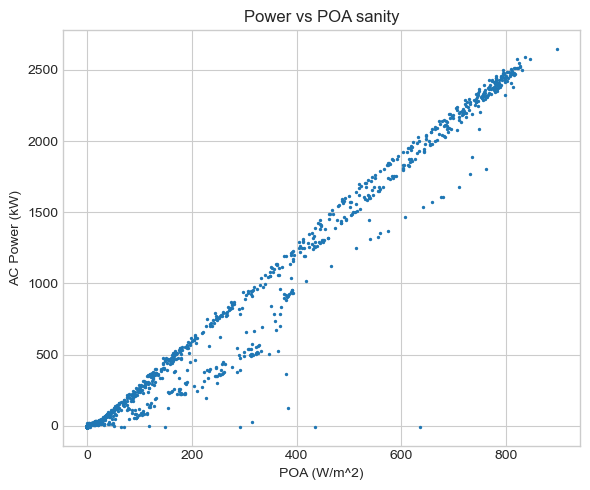

In [41]:
plt.figure(figsize=(14, 3))
pwr.plot()
plt.title("Power quicklook")
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 3))
poa.plot()
plt.title("POA quicklook")
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 3))
tmod.plot()
plt.title("Tmod quicklook")
plt.tight_layout()
plt.show()

# scatter
joined = pd.concat([poa.rename("poa"), pwr.rename("p_kw")], axis=1).dropna()
joined = joined[(joined["poa"] >= 0) & (joined["poa"] <= cfg.max_valid_poa_wm2)]
if len(joined) > 20000:
    joined = joined.sample(20000, random_state=cfg.random_seed)

plt.figure(figsize=(6, 5))
plt.scatter(joined["poa"], joined["p_kw"], s=2)
plt.xlabel("POA (W/m^2)")
plt.ylabel("AC Power (kW)")
plt.title("Power vs POA sanity")
plt.tight_layout()
plt.show()

In [44]:
from pv_fleet_health.dq import dq_report_fleet

dq_report = dq_report_fleet(scada_rs, cfg)
print("DQ report rows:", len(dq_report))
display(dq_report.sort_values("dq_score").head(10))
display(dq_report.sort_values("dq_score", ascending=False).head(10))

save_parquet(dq_report, str(paths.stage_dir / "dq_report.parquet"))

DQ report rows: 1


plant_name  poa_missing_frac_day  \
0  Solar Concept 3721 KWp Lexaina                   0.0   

   tmod_missing_frac_day  p_missing_frac_day  poa_oob_frac  tmod_oob_frac  \
0                    0.0            0.012788           0.0            0.0   

   pf_oob_frac  poa_stuck_frac  tmod_stuck_frac  counter_reset_frac  \
0          0.0        0.377083              0.0            0.509037   

   completeness_score  plausibility_score  stuck_score  counter_score  \
0            0.978687                 1.0          0.5            0.0   

   dq_score monitoring_confidence  
0  0.619672                   Low

plant_name  poa_missing_frac_day  \
0  Solar Concept 3721 KWp Lexaina                   0.0   

   tmod_missing_frac_day  p_missing_frac_day  poa_oob_frac  tmod_oob_frac  \
0                    0.0            0.012788           0.0            0.0   

   pf_oob_frac  poa_stuck_frac  tmod_stuck_frac  counter_reset_frac  \
0          0.0        0.377083              0.0            0.509037   

   completeness_score  plausibility_score  stuck_score  counter_score  \
0            0.978687                 1.0          0.5            0.0   

   dq_score monitoring_confidence  
0  0.619672                   Low